#Trabajo Final Minería de Datos

Se quiere seleccionar a las personas
que realmente están dispuestas a hacer donativos (colaboradores), menos dinero se
gastará en peticiones y más dinero habrá para la causa benéfica.

**Objetivo:** Maximizar el AUC.

**Tarea:**
-Tratar y justificar estrategias de muestreo, missings/outliers.
-Ajustar al menos un árbol, una regresión logística, un random forest y un gradient boosting.
-Interpretación de los rsultados por cada uno de los grupos anteriores.

**CONTROL_NUMBER_M**  -> Identificador único por persona.

**TARGET_B** -> Label binaria dona o no dona.


## Importar Librerías

In [ ]:
!pip3 install pyforest
!pip3 install seaborn
!pip3 install plotly
!pip3 install cufflinks
!pip install scorecardpy

  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14606 sha256=f4125b78d15a57e01fb4f5af55db3203978f93b74f8a1457c27a08dc2a937099
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60634 sha256=26d0b835c9a1dff38d813f0db5fd8ad682be4ddbe6536f33c8f507b49cd3c405
  Stored in directory: /root/.cache/pip/wheels/49/49/e9/7b845548eed3624ce37effdd13e9cb95a99272d692eb9e9e23
Successfully built scorecardpy


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import pyforest
import joblib
from plotly.offline import iplot
import scorecardpy as sc
import copy
from ast import literal_eval
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=True, world_readable=True)

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('max_colwidth',200)

pd.set_option('display.max_columns', None)

# POSIBLES TRANSFORMACIONES

In [ ]:
test_size = 0.15
random_state = 28

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

## REDUCCIÓN CLASES DE UNA CATEGÓRICA CON K-MEANS

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

def fit_reduce_clases(var, df, y, n=5):
  x = []
  for clase in df[var].values:
    if pd.isna(clase):
      x.append(-1)
    else:
      x.append(clase)

  # Calcula la media de la variable de interés para cada clase
  medias_por_clase = {}
  for clase in np.unique(x):
      medias_por_clase[clase] = np.mean(y[x == clase])

  # Convierte las medias a una matriz para usar en KMeans
  X = np.array(list(medias_por_clase.values())).reshape(-1, 1)

  # Número de clústeres deseado
  num_clusters = 5

  # Aplica el algoritmo K-means
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X)

  # Obtén las etiquetas de los clústeres para cada clase
  etiquetas = kmeans.labels_

  # Agrupa las clases según las etiquetas de los clústeres
  clases_agrupadas = {}
  for clase, etiqueta in zip(medias_por_clase.keys(), etiquetas):
    clases_agrupadas[clase] = etiqueta

  return clases_agrupadas

## WOE

In [ ]:
# DEVUELVE TRANSFORMACIÓN WOE Y LAS FILTRADAS
def fit_woe(X, y):
  Xy = copy.deepcopy(X)
  Xy['target'] = y
  woe_resultado = sc.woebin(Xy, y='target', method='tree')
  return woe_resultado

def dame_woe(X, woe_resultado):
  X_woe = sc.woebin_ply(X, woe_resultado)
  X_woe_filtrado = pd.DataFrame()
  for column in X_woe:
    var = column[:-4]
    if woe_resultado[var]['total_iv'][0]>=0.02:
      X_woe_filtrado[column] = X_woe[column]

  return X_woe, X_woe_filtrado

## ONE-HOT ENCODING DE LAS CATEGÓRICAS E IMPUTACIÓN

In [ ]:
# TRANSFORMACIÓN ONE-HOT E IMPUTACIÓN POR KNN RESPECTO A LA MEDIA DEL LABEL,
# POR KNN RESPECTO A LAS COVARIABLES PARA LAS NUMÉRICAS Y POR AUMENTO DE CLASE
# TIPO NA.

def dame_one_hot(X_original, add_classna, add_varna):
  X = copy.deepcopy(X_original)

  for var in add_varna:
    X['na_'+var] = [1 if pd.isna(x) else 0 for x in X[var]]

  for var in add_classna:
    X[var] = [str(x) if not pd.isna(x) else str(-1) for x in X[var]]

  categorical_features = list(X.select_dtypes(include=['object']).columns)

  X_one_hot = pd.get_dummies(X, columns=categorical_features)

  return X_one_hot

def dame_one_hot_new_var(X_original, clases_agrupadas_dict, n):
  X = copy.deepcopy(X_original)
  for var in clases_agrupadas_dict.keys():
    ids = []
    for clase in X[var].values:
      if pd.isna(clase):
        ids.append(-1)
      else:
        ids.append(clase)

    aux = []
    for i in ids:
      if i in clases_agrupadas_dict[var].keys():
        aux.append(clases_agrupadas_dict[var][i])
      else:
        raise ValueError(f'ERROR: CLASE DE LA VARIABLE {var} NO ENCONTRADA!!')

    for new_clas in range(n):
      column_dum = []
      for i in aux:
        if i==new_clas:
          column_dum.append(1)
        else:
          column_dum.append(0)
      X[var+str(new_clas)] = column_dum

  X = X.drop(var,axis=1)
  return X



def fit_imputer(X_one_hot):
  imputer = KNNImputer(n_neighbors=3)
  _ =imputer.fit_transform(X_one_hot)
  return imputer


def imputa(X_one_hot, imputer):
  X = copy.deepcopy(X_one_hot)
  X_one_hot_imputed = imputer.transform(X)
  X_one_hot_imputed = pd.DataFrame(X_one_hot_imputed, columns=X_one_hot.columns)
  return X_one_hot_imputed


In [ ]:
# HACERLO ASÍ NOS PERMITE HACER LA IMPUTACIÓN QUE USAN LAS Y & X CON EL
# Y APLICAR ESTAS TRANSFORMACIONES AL TEST ENTRENAMIENTO

clases_agrupadas = {}
ids = {}
clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train, y_train, n=5)
add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS

'''
PRUEBA_one_hot = dame_one_hot(X_train, add_classna, add_varna)
PRUEBA_one_hot_2 = dame_one_hot_new_var(PRUEBA_one_hot, clases_agrupadas, 5)
imputer = fit_imputer(PRUEBA_one_hot_2)
PRUEBA_one_hot_imputed = imputa(PRUEBA_one_hot_2, imputer)
'''

'\nPRUEBA_one_hot = dame_one_hot(X_train, add_classna, add_varna)\nPRUEBA_one_hot_2 = dame_one_hot_new_var(PRUEBA_one_hot, clases_agrupadas, 5)\nimputer = fit_imputer(PRUEBA_one_hot_2)\nPRUEBA_one_hot_imputed = imputa(PRUEBA_one_hot_2, imputer)\n'

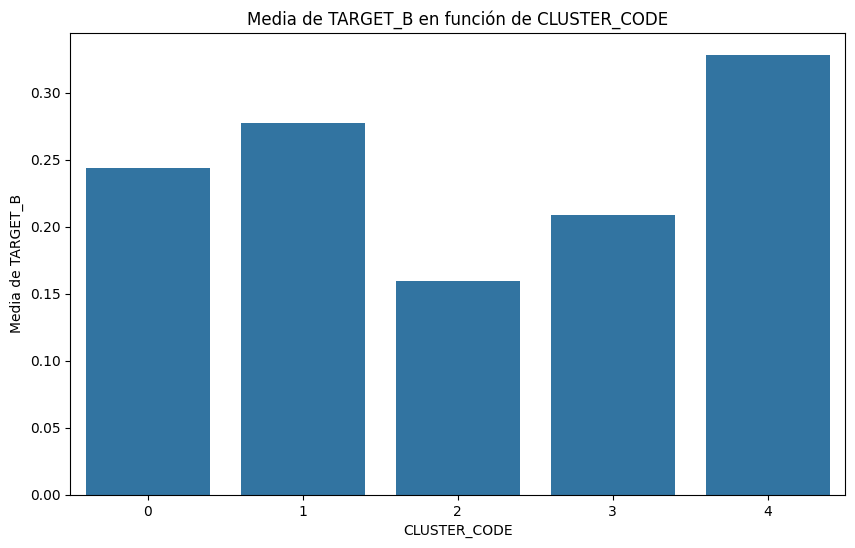

In [ ]:
PRUEBA_one_hot_imputed = copy.deepcopy(X_train)
PRUEBA_one_hot_imputed['TARGET_B'] = y_train
# Obtener el número de valores únicos para determinar el número de bins
PRUEBA_one_hot_imputed['CLUSTER_CODE'] = [clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(i) else clases_agrupadas['CLUSTER_CODE'][i] for i in X_train['CLUSTER_CODE']]
medias_por_clase = PRUEBA_one_hot_imputed.groupby('CLUSTER_CODE')['TARGET_B'].mean().reset_index()

# Crear el barplot
plt.figure(figsize=(10, 6))
sns.barplot(x='CLUSTER_CODE', y='TARGET_B', data=medias_por_clase)
plt.title('Media de TARGET_B en función de CLUSTER_CODE')
plt.xlabel('CLUSTER_CODE')
plt.ylabel('Media de TARGET_B')

# Guardar la imagen
plt.savefig('barplot.png')

# Mostrar el gráfico
plt.show()



In [ ]:
PRUEBA_one_hot_imputed.head(2)

## Importar datos y análisis previo

**VARIABLES TIPO OBJECT (TODAS CATEGÓRICAS):**

URBANICITY             6 clases

SES                    5 clases

HOME_OWNER             2 clases

DONOR_GENDER           4 clases

OVERLAY_SOURCE         4 clases

RECENCY_STATUS_96NK    6 clases



---



**VARIABLES CON MISSING:**

Se muestra la diferencia de media de la y entre Missing-NoMissing

DONOR_GENDER: -0.01 (CATEGÓRICA obj)

**CLUSTER_CODE:** 0.05 (CATEGÓRICA 54 clases float GRUPO SOCIOECONÓMICO)

**INCOME_GROUP:** 0.01 (CATEGÓRICA 7 clases float GRUPO)

**WEALTH_RATING:** -0.03 (CATEGÓRICA 10 clases float GRUPO)

MONTHS_SINCE_LAST_PROM_RESP: -0.10 (NUM float)



---



**VARIABLES NUMÉRICAS QUE SON CLASES Y NO SON 0-1**

CLUSTER_CODE -> No conviene que sea continua. Muchas clases, podríamos hacer el test de Tuckey.

INCOME_GROUP -> Plot sugiere imputar missing como clase con proporción de positivos más semejante y tratar esta variable como continua al observar una tendencia.

WEALTH_RATING -> No es tan claro qué hacer. Hay una leve tendencia, se podría tratar como continua.



In [ ]:
# Cargar los datos en dataframes
alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
#profesores_df = pd.read_csv('veteranos_tablaProfe_CSV.csv')

# Visualización y análisis de los datos
print("\n### Datos ###")
display(alumnos_df.head(10))


### Datos ###


,CONTROL_NUMBER_N,TARGET_B,MONTHS_SINCE_ORIGIN,DONOR_AGE,IN_HOUSE,URBANICITY,SES,CLUSTER_CODE,HOME_OWNER,DONOR_GENDER,INCOME_GROUP,PUBLISHED_PHONE,OVERLAY_SOURCE,MOR_HIT_RATE,WEALTH_RATING,MEDIAN_HOME_VALUE,MEDIAN_HOUSEHOLD_INCOME,PCT_OWNER_OCCUPIED,PER_CAPTITA_INCOME,PCT_MALE_MILITARY,PCT_MALE_VETERANS,PCT_VIETNAM_VETERANS,PCT_WWII_VETERANS,PEP_STAR,RECENT_STAR_STATUS,RECENCY_STATUS_96NK,FREQUENCY_STATUS_97NK,RECENT_RESPONSE_PROP,RECENT_AVG_GIFT_AMT,RECENT_CARD_RESPONSE_PROP,RECENT_AVG_CARD_GIFT_AMT,RECENT_RESPONSE_COUNT,RECENT_CARD_RESPONSE_COUNT,MONTHS_SINCE_LAST_PROM_RESP,LIFETIME_CARD_PROM,LIFETIME_PROM,LIFETIME_GIFT_AMOUNT,LIFETIME_GIFT_COUNT,LIFETIME_AVG_GIFT_AMT,LIFETIME_GIFT_RANGE,LIFETIME_MAX_GIFT_AMT,LIFETIME_MIN_GIFT_AMT,LAST_GIFT_AMT,CARD_PROM_12,NUMBER_PROM_12,MONTHS_SINCE_LAST_GIFT,MONTHS_SINCE_FIRST_GIFT,FILE_AVG_GIFT,FILE_CARD_GIFT
0,1,1,65,NaN,0,S,2,17.0,U,F,2.0,0,M,23,1.0,625,247,46,13242,0,34,37,27,0,0,A,4,0.238,7.00,0.400,6.25,5,4,16.0,18,46,65.0,9,7.22,7.0,12.0,5.0,10.0,6,14,16,55,7.22,5
1,2,1,29,NaN,0,S,2,17.0,U,F,NaN,0,N,0,NaN,1491,396,74,26286,0,37,21,42,0,0,A,2,0.214,14.00,0.143,20.00,3,1,21.0,11,26,42.0,3,14.00,10.0,20.0,10.0,20.0,6,13,21,32,14.00,1
2,3,0,17,40.0,0,T,1,35.0,H,F,6.0,1,B,1,NaN,1336,490,84,21694,1,41,27,38,0,0,F,1,0.143,20.00,0.333,20.00,1,1,19.0,6,16,20.0,1,20.00,0.0,20.0,20.0,20.0,4,10,19,19,20.00,1
3,4,0,89,72.0,0,C,2,28.0,U,M,7.0,0,P,0,5.0,675,226,74,12605,0,37,27,54,1,0,A,1,0.091,25.00,0.182,25.00,2,2,17.0,24,65,112.0,7,16.00,20.0,25.0,5.0,25.0,6,15,17,88,16.00,6
4,5,0,29,NaN,0,C,2,27.0,U,F,5.0,0,M,4,NaN,1263,309,35,12818,2,44,50,19,0,0,A,2,0.214,14.67,0.429,14.67,3,3,17.0,11,24,44.0,3,14.67,11.0,20.0,9.0,20.0,6,12,17,33,14.67,3
5,6,0,65,83.0,0,S,2,16.0,U,F,1.0,1,B,1,7.0,694,416,98,14995,0,27,44,14,0,0,A,3,0.211,7.50,0.000,0.00,4,0,15.0,16,40,46.0,8,5.75,9.0,10.0,1.0,10.0,5,12,15,64,5.75,2
6,7,1,89,77.0,0,S,2,18.0,H,M,3.0,1,B,12,NaN,793,429,89,12976,0,25,61,16,1,0,A,3,0.158,7.33,0.000,0.00,3,0,18.0,22,64,86.0,13,6.62,9.0,9.0,0.0,0.0,6,18,14,81,6.62,3
7,8,0,101,69.0,0,U,1,3.0,H,F,7.0,0,P,0,4.0,4224,314,28,17898,0,11,22,42,1,5,A,1,0.136,16.67,0.182,17.00,3,2,20.0,29,71,159.0,12,13.25,20.0,25.0,5.0,18.0,6,13,20,105,13.25,8
8,9,1,89,72.0,0,C,3,30.0,H,M,2.0,1,B,22,4.0,487,273,63,13272,0,27,17,48,1,1,S,4,0.529,5.00,0.636,5.00,9,7,17.0,27,62,140.0,28,5.00,0.0,5.0,5.0,5.0,6,13,17,92,5.00,19
9,10,0,41,55.0,0,U,4,10.0,H,M,3.0,0,P,0,NaN,241,178,33,7276,0,35,0,34,0,0,A,1,0.095,15.00,0.100,16.00,2,1,16.0,15,36,61.0,5,12.20,11.0,16.0,5.0,16.0,6,12,16,40,12.20,1


In [ ]:
import math

In [ ]:
var = 'CLUSTER_CODE' # 'CLUSTER_CODE'
x = []
for clase in X_train[var].values: # alumnos_df[var].values
  if math.isnan(clase):
    x.append(-1)
  else:
    x.append(clase)

y = y_train # alumnos_df['TARGET_B']
clases_unicas = np.unique(x)

# Calcular la media de los valores 1 para cada clase
medias = [np.mean(y[x == c]) for c in clases_unicas]

# Graficar las medias
plt.bar(clases_unicas, medias, align='center', alpha=0.5)
plt.xlabel('Clase')
plt.ylabel('Media de 1 en la clase')
plt.title('Media de 1 en cada clase')
plt.xticks(clases_unicas)
plt.show()

NameError: name 'X_train' is not defined

In [ ]:
print("\nInformación del DataFrame:")
alumnos_df.info()


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13422 entries, 0 to 13421
Data columns (total 49 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CONTROL_NUMBER_N             13422 non-null  int64  
 1   TARGET_B                     13422 non-null  int64  
 2   MONTHS_SINCE_ORIGIN          13422 non-null  int64  
 3   DONOR_AGE                    10101 non-null  float64
 4   IN_HOUSE                     13422 non-null  int64  
 5   URBANICITY                   13422 non-null  object 
 6   SES                          13422 non-null  object 
 7   CLUSTER_CODE                 13106 non-null  float64
 8   HOME_OWNER                   13422 non-null  object 
 9   DONOR_GENDER                 13422 non-null  object 
 10  INCOME_GROUP                 10361 non-null  float64
 11  PUBLISHED_PHONE              13422 non-null  int64  
 12  OVERLAY_SOURCE               13422 non-null  o

In [ ]:
print("\nEstadísticas descriptivas:")
display(alumnos_df.describe().T)
display(alumnos_df.describe(include=object).T)


Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
CONTROL_NUMBER_N,13422.0,6711.500000,3874.741991,1.00,3356.250,6711.500,10066.750,13422.00
TARGET_B,13422.0,0.248622,0.432230,0.00,0.000,0.000,0.000,1.00
MONTHS_SINCE_ORIGIN,13422.0,73.437491,41.225140,5.00,29.000,65.000,113.000,137.00
DONOR_AGE,10101.0,58.843877,16.682388,2.00,47.000,60.000,73.000,87.00
IN_HOUSE,13422.0,0.073238,0.260536,0.00,0.000,0.000,0.000,1.00
CLUSTER_CODE,13106.0,27.920647,14.448756,1.00,15.000,28.000,40.000,53.00
INCOME_GROUP,10361.0,3.901650,1.873530,1.00,2.000,4.000,5.000,7.00
PUBLISHED_PHONE,13422.0,0.497243,0.500011,0.00,0.000,0.000,1.000,1.00
MOR_HIT_RATE,13422.0,3.427433,9.942210,0.00,0.000,0.000,3.000,241.00
WEALTH_RATING,7314.0,5.020782,2.808994,0.00,3.000,5.000,8.000,9.00


,count,unique,top,freq
URBANICITY,13422,6,S,3139
SES,13422,5,2,6440
HOME_OWNER,13422,2,H,7310
DONOR_GENDER,13422,4,F,7214
OVERLAY_SOURCE,13422,4,B,6044
RECENCY_STATUS_96NK,13422,6,A,8294


In [ ]:
alumnos_df.select_dtypes(include=['object']).nunique()

URBANICITY             6
SES                    5
HOME_OWNER             2
DONOR_GENDER           4
OVERLAY_SOURCE         4
RECENCY_STATUS_96NK    6
dtype: int64

In [ ]:
alumnos_df.nunique()[0:] #Las variables con valor 2 son binarias

CONTROL_NUMBER_N               13422
TARGET_B                           2
MONTHS_SINCE_ORIGIN               24
DONOR_AGE                         79
IN_HOUSE                           2
URBANICITY                         6
SES                                5
CLUSTER_CODE                      53
HOME_OWNER                         2
DONOR_GENDER                       4
INCOME_GROUP                       7
PUBLISHED_PHONE                    2
OVERLAY_SOURCE                     4
MOR_HIT_RATE                      65
WEALTH_RATING                     10
MEDIAN_HOME_VALUE               2792
MEDIAN_HOUSEHOLD_INCOME          869
PCT_OWNER_OCCUPIED               100
PER_CAPTITA_INCOME              9059
PCT_MALE_MILITARY                 63
PCT_MALE_VETERANS                 81
PCT_VIETNAM_VETERANS              88
PCT_WWII_VETERANS                100
PEP_STAR                           2
RECENT_STAR_STATUS                23
RECENCY_STATUS_96NK                6
FREQUENCY_STATUS_97NK              4
R

In [ ]:
alumnos_df.duplicated().value_counts() #No hay valores duplicados

False    13422
dtype: int64

In [ ]:
def missing(df):
    missing_number = df.isnull().sum()
    missing_percent = (df.isnull().sum() / df.isnull().count())

    # Filtrar solo las columnas que tienen valores missing
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    missing_values = missing_values[missing_values['Missing_Number'] > 0]

    return missing_values

# Ejemplo de uso
missing(alumnos_df)

,Missing_Number,Missing_Percent
DONOR_AGE,3321,0.247430
CLUSTER_CODE,316,0.023543
INCOME_GROUP,3061,0.228058
WEALTH_RATING,6108,0.455074
MONTHS_SINCE_LAST_PROM_RESP,170,0.012666


Diferencia media variable respuesta en los datos missing y datos sin missing:

In [ ]:
def missing_difference(df, column):
    # Filtrar observaciones con valores missing y sin missing
    missing_data = df[df[column].isnull()]
    non_missing_data = df[df[column].notnull()]

    # Calcular la diferencia de media para TARGET_B
    mean_missing = missing_data['TARGET_B'].mean()
    mean_non_missing = non_missing_data['TARGET_B'].mean()

    return mean_missing, mean_non_missing

In [ ]:
columns_with_missing = missing(alumnos_df).index.tolist()

for column in columns_with_missing:
    mean_missing, mean_non_missing = missing_difference(alumnos_df, column)
    print(f'Variable: {column}, Media Missing: {mean_missing:.2f}, Media sin Missing: {mean_non_missing:.2f}, Diferencia: {mean_missing - mean_non_missing:.2f}')

Variable: DONOR_AGE, Media Missing: 0.24, Media sin Missing: 0.25, Diferencia: -0.01
Variable: CLUSTER_CODE, Media Missing: 0.30, Media sin Missing: 0.25, Diferencia: 0.05
Variable: INCOME_GROUP, Media Missing: 0.26, Media sin Missing: 0.25, Diferencia: 0.01
Variable: WEALTH_RATING, Media Missing: 0.23, Media sin Missing: 0.26, Diferencia: -0.03
Variable: MONTHS_SINCE_LAST_PROM_RESP, Media Missing: 0.15, Media sin Missing: 0.25, Diferencia: -0.10


Ploteamos una muestra de estas columnas con missing

In [ ]:
# Seleccionar las columnas especificadas
columns_to_display = ['DONOR_AGE', 'CLUSTER_CODE', 'INCOME_GROUP', 'WEALTH_RATING', 'MONTHS_SINCE_LAST_PROM_RESP']
subset_alumnos_df = alumnos_df[columns_to_display]

# Mostrar el DataFrame usando display
display(subset_alumnos_df.head(50))

Veamos como se distribuye la variable respuesta:

In [ ]:
def first_looking(col,df):
    print("column name    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print(df[col].value_counts(dropna = False))
first_looking("TARGET_B",alumnos_df)

column name    :  TARGET_B
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  2
0    10085
1     3337
Name: TARGET_B, dtype: int64


In [ ]:
numerical = alumnos_df.drop(['TARGET_B', 'CONTROL_NUMBER_N'], axis=1).select_dtypes('number').columns
binary_numerical_variables = alumnos_df[numerical].nunique()[alumnos_df[numerical].nunique() == 2].index

categorical = alumnos_df.drop(['TARGET_B', 'CONTROL_NUMBER_N'], axis=1).select_dtypes('object').columns
binary_categorical_variables = alumnos_df[categorical].nunique()[alumnos_df[categorical].nunique() == 2].index

print(f'Número de variables numéricas: {len(numerical)}')
print(f'Número de variables categóricas: {len(categorical)}')
print(f'Número de variables numéricas binarias: {len(binary_numerical_variables)}')
print(f'Número de variables categóricas binarias: {len(binary_categorical_variables)}')

print(f'\nNumerical Columns: {numerical}')
print(f'\nCategorical Columns: {categorical}')

Número de variables numéricas: 41
Número de variables categóricas: 6
Número de variables numéricas binarias: 3
Número de variables categóricas binarias: 1

Numerical Columns: Index(['MONTHS_SINCE_ORIGIN', 'DONOR_AGE', 'IN_HOUSE', 'CLUSTER_CODE',
       'INCOME_GROUP', 'PUBLISHED_PHONE', 'MOR_HIT_RATE', 'WEALTH_RATING',
       'MEDIAN_HOME_VALUE', 'MEDIAN_HOUSEHOLD_INCOME', 'PCT_OWNER_OCCUPIED',
       'PER_CAPTITA_INCOME', 'PCT_MALE_MILITARY', 'PCT_MALE_VETERANS',
       'PCT_VIETNAM_VETERANS', 'PCT_WWII_VETERANS', 'PEP_STAR',
       'RECENT_STAR_STATUS', 'FREQUENCY_STATUS_97NK', 'RECENT_RESPONSE_PROP',
       'RECENT_AVG_GIFT_AMT', 'RECENT_CARD_RESPONSE_PROP',
       'RECENT_AVG_CARD_GIFT_AMT', 'RECENT_RESPONSE_COUNT',
       'RECENT_CARD_RESPONSE_COUNT', 'MONTHS_SINCE_LAST_PROM_RESP',
       'LIFETIME_CARD_PROM', 'LIFETIME_PROM', 'LIFETIME_GIFT_AMOUNT',
       'LIFETIME_GIFT_COUNT', 'LIFETIME_AVG_GIFT_AMT', 'LIFETIME_GIFT_RANGE',
       'LIFETIME_MAX_GIFT_AMT', 'LIFETIME_MIN_GIFT_AMT

### Histogramas variables numéricas para la detección de outliers

In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab'

alumnos_df[numerical].iloc[:, :10].iplot(kind='histogram', subplots=True, bins=50)

In [ ]:
count_above_75 = len(alumnos_df[alumnos_df['MOR_HIT_RATE'] > 75])

print(f'Número de valores en la columna MOR_HIT_RATE por encima de 75: {count_above_75}')

display(alumnos_df[alumnos_df['MOR_HIT_RATE'] > 75]['MOR_HIT_RATE'])

Número de valores en la columna MOR_HIT_RATE por encima de 75: 13


528      240
1419     240
1640     240
2619     240
2728     240
5309     241
7074     240
9458     241
10062    240
11825    240
11933    240
12323    240
12863    240
Name: MOR_HIT_RATE, dtype: int64

In [ ]:
alumnos_df[numerical].iloc[:, 10:18].iplot(kind='histogram', subplots=True, bins=50)

In [ ]:
alumnos_df[numerical].iloc[:, 18:26].iplot(kind='histogram', subplots=True, bins=50)

In [ ]:
valores_neg = len(alumnos_df[alumnos_df['MONTHS_SINCE_LAST_PROM_RESP'] < 0])

print(f'Número de valores en la columna MONTHS_SINCE_LAST_PROM_RESP negativos: {valores_neg}')

display(alumnos_df[alumnos_df['MONTHS_SINCE_LAST_PROM_RESP'] <0]['MONTHS_SINCE_LAST_PROM_RESP'])

Número de valores en la columna MONTHS_SINCE_LAST_PROM_RESP negativos: 8


682      -9.0
4084     -9.0
5814    -11.0
7467     -9.0
10040   -10.0
10615   -12.0
10986   -10.0
13378   -11.0
Name: MONTHS_SINCE_LAST_PROM_RESP, dtype: float64

In [ ]:
alumnos_df[numerical].iloc[:, 26:34].iplot(kind='histogram', subplots=True, bins=50)

In [ ]:
alumnos_df[numerical].iloc[:, 34:41].iplot(kind='histogram', subplots=True, bins=50)

### Histograma Variables categóricas
Se observa que hay categorías con ?

In [ ]:
alumnos_df[categorical].iplot(kind='histogram', subplots=True, bins=50)

### Box-Plots variables numéricas enfrentando cuando variable respuesta es 0 o 1.

In [ ]:
plt.figure(figsize=(20,20))
index = 0

for feature in numerical[0:12]:
      index += 1
      plt.subplot(4, 3, index)
      sns.boxplot(x='TARGET_B', y=feature, data=alumnos_df)
      plt.title(feature)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
index = 0

for feature in numerical[12:24]:
      index += 1
      plt.subplot(4, 3, index)
      sns.boxplot(x='TARGET_B', y=feature, data=alumnos_df)
      plt.title(feature)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
index = 0

for feature in numerical[24:36]:
      index += 1
      plt.subplot(4, 3, index)
      sns.boxplot(x='TARGET_B', y=feature, data=alumnos_df)
      plt.title(feature)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
index = 0

for feature in numerical[36:41]:
      index += 1
      plt.subplot(4, 3, index)
      sns.boxplot(x='TARGET_B', y=feature, data=alumnos_df)
      plt.title(feature)

plt.tight_layout()
plt.show()

### Histograma variables categóricas según variable respuesta

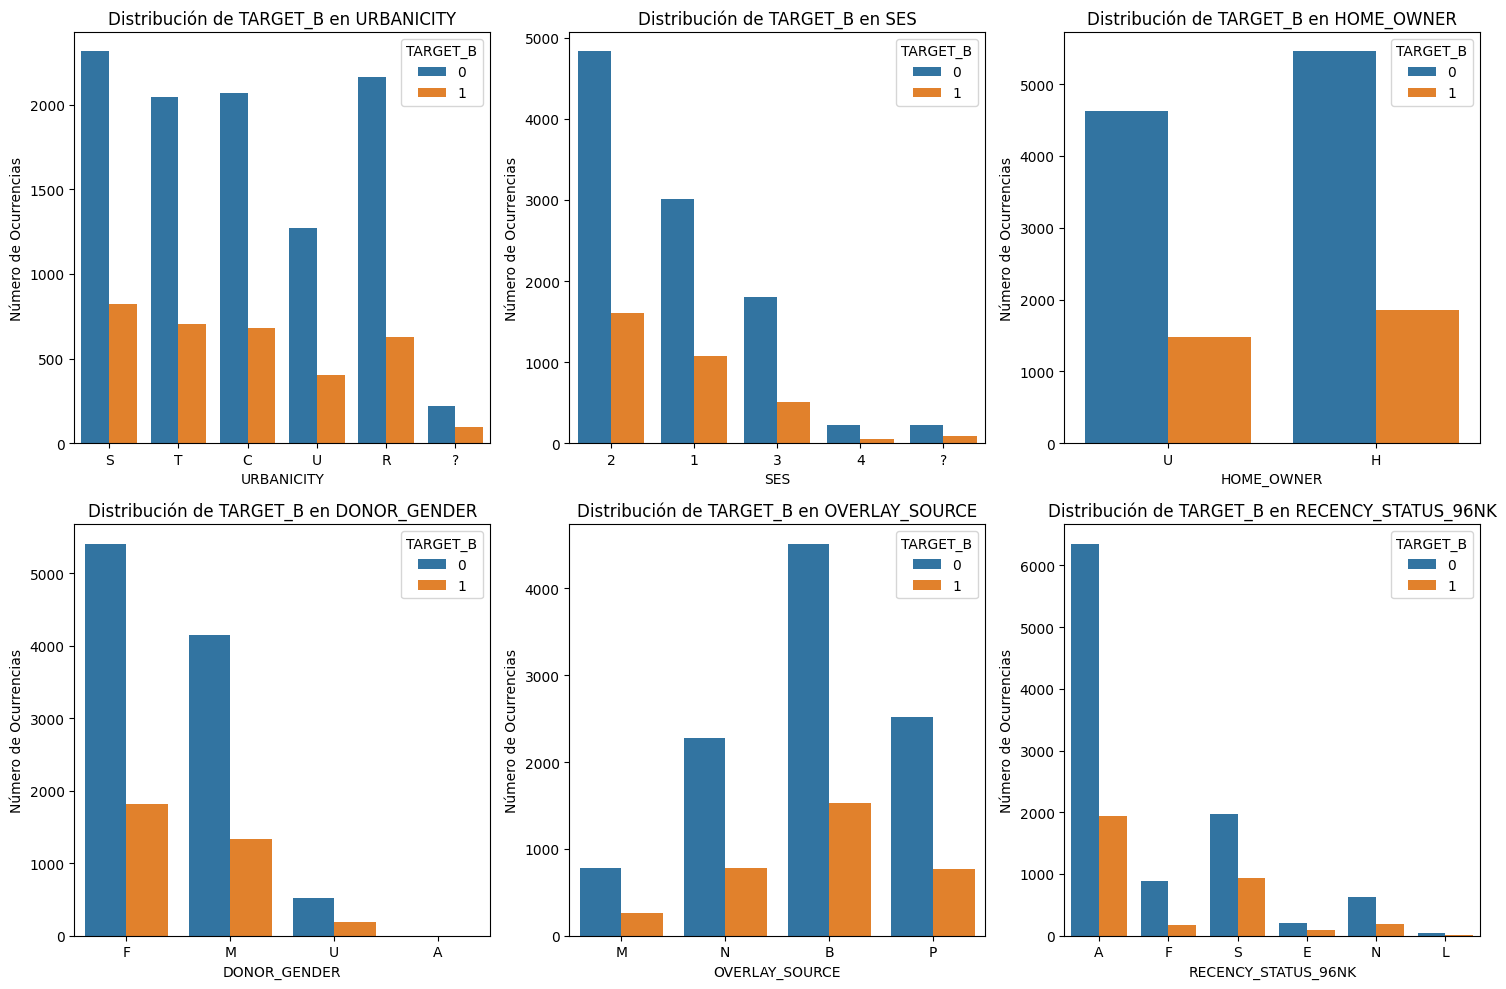

In [ ]:
# Configurar el tamaño de la figura
plt.figure(figsize=(15, 10))

# Iterar sobre las columnas categóricas
for i, category in enumerate(categorical, 1):
    plt.subplot(2, 3, i)  # Cambia el número según el número de columnas categóricas
    sns.countplot(x=category, hue="TARGET_B", data=alumnos_df)
    plt.xlabel(category)
    plt.ylabel("Número de Ocurrencias")
    plt.title(f'Distribución de TARGET_B en {category}')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

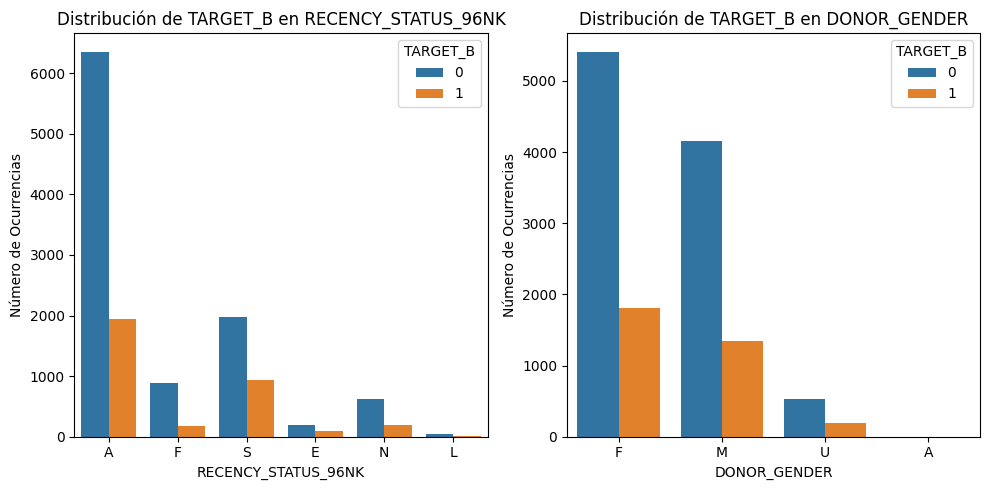

In [ ]:
# Configurar el tamaño de la figura
plt.figure(figsize=(10, 5))

# Lista de columnas categóricas de interés
categorical_columns_of_interest = ['RECENCY_STATUS_96NK', 'DONOR_GENDER']

# Iterar sobre las columnas categóricas de interés
for i, category in enumerate(categorical_columns_of_interest, 1):
    plt.subplot(1, 2, i)  # Ajusta según el número de columnas categóricas de interés
    sns.countplot(x=category, hue="TARGET_B", data=alumnos_df)
    plt.xlabel(category)
    plt.ylabel("Número de Ocurrencias")
    plt.title(f'Distribución de TARGET_B en {category}')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()


### Media variable respuesta en variables continuas por intervalos:
Nota: Faltan variables por graficar, puede ser interesante para ver que hacer con variables WOE

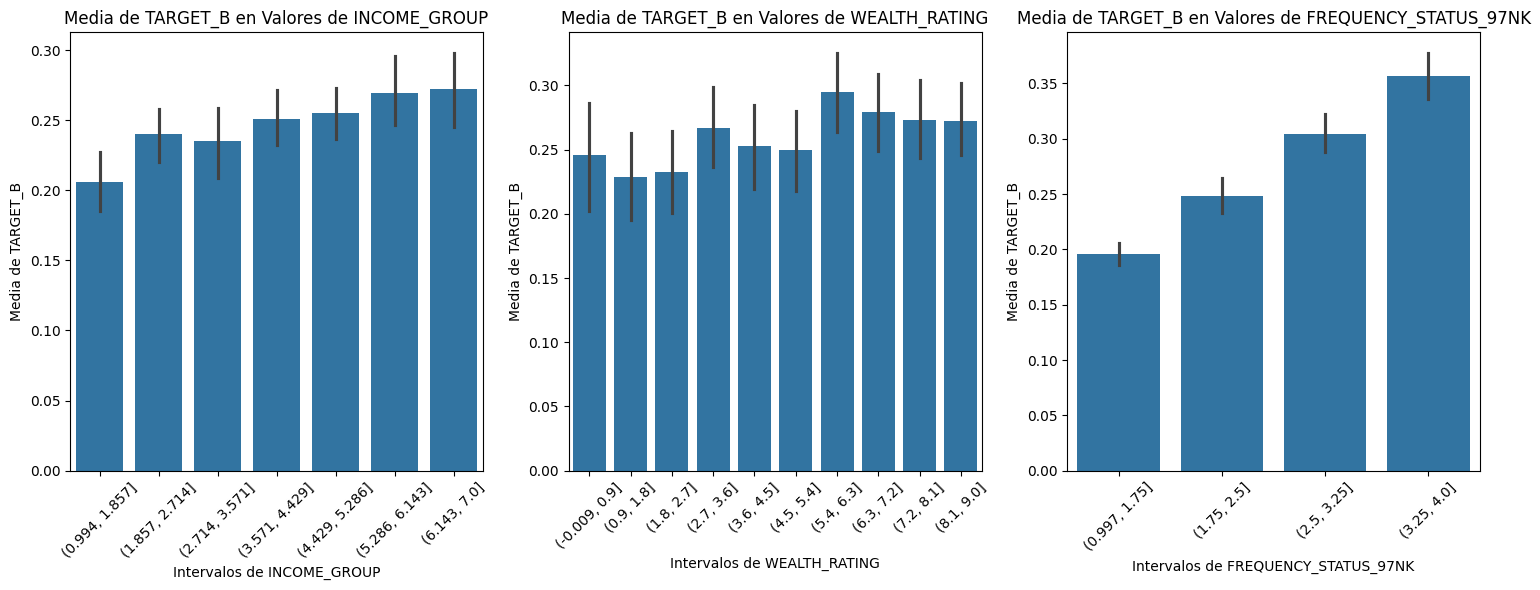

In [ ]:
# Lista de columnas numéricas de interés
numerical_columns_of_interest = ['INCOME_GROUP', 'WEALTH_RATING','FREQUENCY_STATUS_97NK']

# Crear una copia del DataFrame original
alumnos_df_copy = alumnos_df.copy()

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 6))

# Obtener el número total de columnas numéricas de interés
num_numerical_columns = len(numerical_columns_of_interest)

# Iterar sobre las columnas numéricas de interés
for i, numerical_column in enumerate(numerical_columns_of_interest, 1):
    # Obtener el número de valores únicos para determinar el número de bins
    num_bins = alumnos_df_copy[numerical_column].nunique()

    # Crear una nueva columna 'numerical_bin' para agrupar la variable numérica en intervalos
    alumnos_df_copy['numerical_bin'] = pd.cut(alumnos_df_copy[numerical_column], bins=num_bins)

    # Crear un gráfico de barras para la media de 'TARGET_B' por intervalos de la variable numérica
    plt.subplot(1, num_numerical_columns, i)  # Ajusta según el número total de columnas numéricas de interés
    sns.barplot(x='numerical_bin', y='TARGET_B', data=alumnos_df_copy)

    # Añadir etiquetas y título
    plt.xlabel(f'Intervalos de {numerical_column}')
    plt.ylabel('Media de TARGET_B')
    plt.title(f'Media de TARGET_B en Valores de {numerical_column}')

    # Rotar las etiquetas del eje x para mayor legibilidad
    plt.xticks(rotation=45)

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()


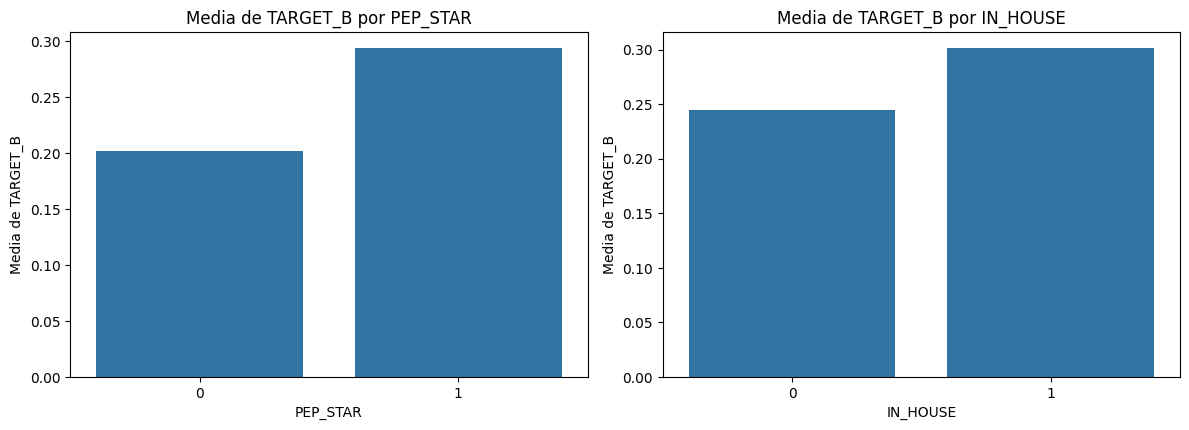

In [ ]:
# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Lista de variables binarias y categóricas de interés
binary_and_categorical_columns = ['PEP_STAR',  'IN_HOUSE']

# Iterar sobre las columnas de interés
for i, column in enumerate(binary_and_categorical_columns, 1):
    plt.subplot(2, 2, i)  # Ajusta según el número de columnas de interés

    if column == 'HOME_OWNER':
        # Gráfico de barras para la media de 'TARGET_B' por valores 'U' y 'H' en 'HOME_OWNER'
        sns.barplot(x=column, y='TARGET_B', data=alumnos_df, ci=None)
    else:
        # Gráfico de barras para la media de 'TARGET_B' por valores 0 y 1 en las variables binarias
        sns.barplot(x=column, y='TARGET_B', data=alumnos_df, ci=None)

    # Añadir etiquetas y título
    plt.xlabel(column)
    plt.ylabel('Media de TARGET_B')
    plt.title(f'Media de TARGET_B por {column}')

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()


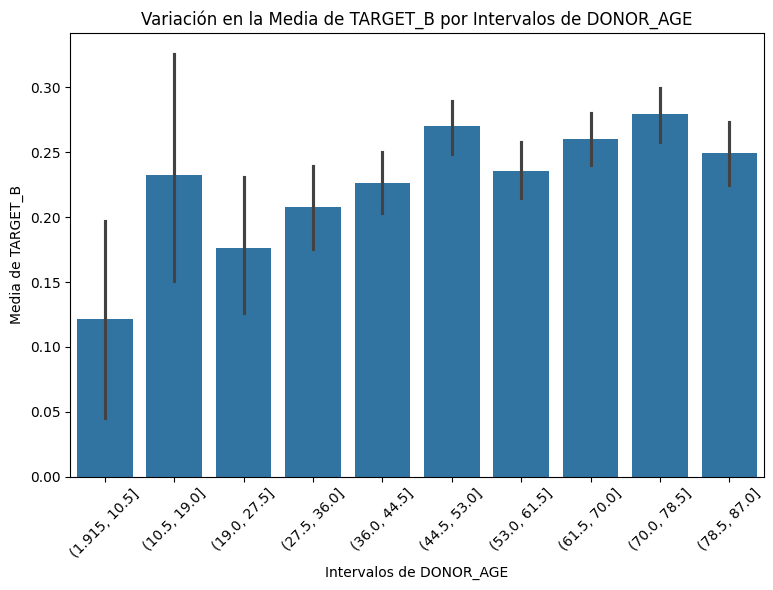

In [ ]:
# Crear una copia del DataFrame original
alumnos_df_copy = alumnos_df.copy()

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 6))

# Lista de columnas numéricas de interés
numerical_columns_of_interest = ['DONOR_AGE']

# Iterar sobre las columnas numéricas de interés
for i, numerical_column in enumerate(numerical_columns_of_interest, 1):

    # Crear una nueva columna 'numerical_bin' para agrupar la variable numérica en intervalos
    alumnos_df_copy['numerical_bin'] = pd.cut(alumnos_df_copy[numerical_column], bins=10)

    # Crear un gráfico de barras para la media de 'TARGET_B' por intervalos de la variable numérica
    plt.subplot(1, 2, i)  # Ajusta según el número de columnas numéricas de interés
    sns.barplot(x='numerical_bin', y='TARGET_B', data=alumnos_df_copy)

    # Añadir etiquetas y título
    plt.xlabel(f'Intervalos de {numerical_column}')
    plt.ylabel('Media de TARGET_B')
    plt.title(f'Variación en la Media de TARGET_B por Intervalos de {numerical_column}')

    # Rotar las etiquetas del eje x para mayor legibilidad
    plt.xticks(rotation=45)

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

ValueError: num must be an integer with 1 <= num <= 6, not 7

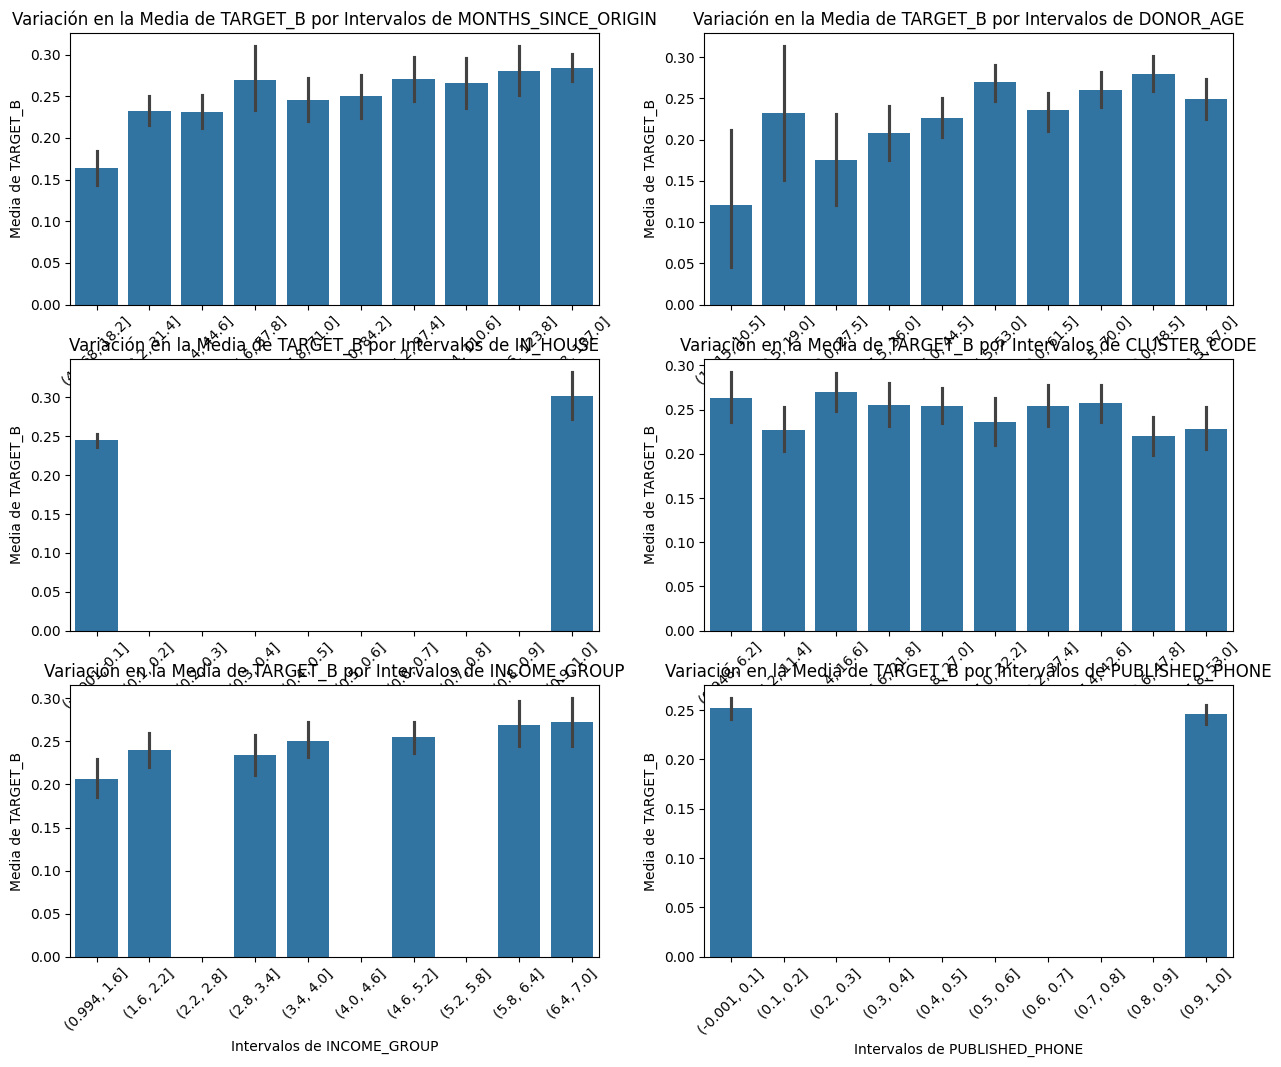

In [ ]:
# Crear una copia del DataFrame original
alumnos_df_copy = alumnos_df.copy()

# Configurar el tamaño de la figura
plt.figure(figsize=(15, 12))

# Iterar sobre las columnas numéricas
for i, numerical_column in enumerate(numerical, 1):
    # Crear una nueva columna 'numerical_bin' para agrupar la variable numérica en intervalos
    alumnos_df_copy['numerical_bin'] = pd.cut(alumnos_df_copy[numerical_column], bins=10)  # Ajusta el número de bins según tus necesidades

    # Crear un gráfico de barras para la media de 'TARGET_B' por intervalos de la variable numérica
    plt.subplot(3, 2, i)  # Ajusta según el número de columnas numéricas
    sns.barplot(x='numerical_bin', y='TARGET_B', data=alumnos_df_copy)

    # Añadir etiquetas y título
    plt.xlabel(f'Intervalos de {numerical_column}')
    plt.ylabel('Media de TARGET_B')
    plt.title(f'Variación en la Media de TARGET_B por Intervalos de {numerical_column}')

    # Rotar las etiquetas del eje x para mayor legibilidad
    plt.xticks(rotation=45)

# Ajustar el diseño y mostrar la figura
plt.tight_layout()
plt.show()

## ENTRENAMIENTO RANDOM FOREST CON KNN IMPUTER

Problema, no tolera valores missing. Hay que hacer imputación.

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

# Definir variables predictoras y variable objetivo
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

# Dividir los datos en conjunto de entrenamiento y prueba (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Configurar las columnas para el ColumnTransformer
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', imputer, numerical)
    ],
    remainder='passthrough'  # Mantiene las columnas no transformadas
)

# Definir el clasificador RandomForest y los hiperparámetros a ajustar
rf_classifier = RandomForestClassifier(class_weight = 'balanced')
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [10, 15],
    'classifier__min_samples_leaf': [10, 20]
}

# Crear el pipeline con ColumnTransformer y RandomForest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

# Configurar StratifiedKFold
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar GridSearchCV con AUC como métrica
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=stratified_cv,error_score='raise')

# Realizar la búsqueda en la cuadrícula utilizando el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Predicciones en el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Evaluar el rendimiento en el conjunto de prueba
roc_auc = roc_auc_score(y_test, y_pred)
print("Curva area ROC conjunto de prueba:", roc_auc)

### Prueba Label Encoder

In [ ]:

from sklearn.preprocessing import LabelEncoder

# Crear una instancia de LabelEncoder
label_encoder = LabelEncoder()

# Datos de ejemplo con una columna categórica
data = pd.DataFrame({'fruta': ['manzana', 'banana', 'manzana', 'uva', 'banana']})

# Aplicar LabelEncoder a la columna 'fruta'
data['fruta_codificada'] = label_encoder.fit_transform(data['fruta'])

print(data)


### RANDOM FOREST CON WOE:


In [ ]:
pip install imbalanced-learn

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import copy
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

class WOEBinningTransformer:
    def __init__(self, woe_resultado):
        self.woe_resultado = woe_resultado

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_woe = sc.woebin_ply(X, self.woe_resultado)
        return X_woe

    def get_params(self, deep=True):
        return {'woe_resultado': self.woe_resultado}


# Definir variables predictoras y variable objetivo
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

# Dividir los datos en conjunto de entrenamiento y prueba (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Crear una copia de X_train para el procesamiento WOE
Xy_train = pd.concat([X_train, y_train], axis=1)


# Aplicar WOE a todas las variables predictoras
woe_resultado = sc.woebin(Xy_train, y='TARGET_B', method='tree')

# Configurar las columnas para el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('woe', WOEBinningTransformer(woe_resultado), X.columns.tolist())  # Provide the list of columns
    ],
    remainder='passthrough'  # Mantiene las columnas no transformadas
)


# Definir el clasificador RandomForest y los hiperparámetros a ajustar
rf_classifier = RandomForestClassifier(class_weight='balanced')
param_grid = {
    'classifier__n_estimators': [100,200,300],
    'classifier__max_depth': [None,20,30],
    'classifier__min_samples_split': [15,30],
    'classifier__min_samples_leaf': [15,30]
}

# Crear el pipeline con ColumnTransformer y RandomForest
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_classifier)
])

# Aplicar oversampling al conjunto de entrenamiento
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Configurar StratifiedKFold
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar GridSearchCV con AUC como métrica
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=stratified_cv, error_score='raise')

# Realizar la búsqueda en la cuadrícula utilizando el conjunto de entrenamiento
grid_search.fit(X_train_resampled, y_train_resampled)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Predicciones en el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Evaluar el rendimiento en el conjunto de prueba
roc_auc = roc_auc_score(y_test, y_pred)
print("Curva área ROC conjunto de prueba:", roc_auc)

In [ ]:
from sklearn.metrics import confusion_matrix
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

In [ ]:
# Predicciones en el conjunto de prueba
y_pred_train = grid_search.predict(X_train)

# Evaluar el rendimiento en el conjunto de prueba
roc_auc = roc_auc_score(y_train, y_pred_train)
print("Curva área ROC conjunto de prueba:", roc_auc)

### Random Forest + oversampling + woe

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import copy
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import FunctionTransformer

class WOEBinningTransformer:
    def __init__(self, woe_resultado):
        self.woe_resultado = woe_resultado

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_woe = sc.woebin_ply(X, self.woe_resultado)
        return X_woe

    def get_params(self, deep=True):
        return {'woe_resultado': self.woe_resultado}

from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler

class OversamplingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_strategy='auto', random_state=None):
        self.sampling_strategy = sampling_strategy
        self.random_state = random_state
        self.oversampler = RandomOverSampler(sampling_strategy=self.sampling_strategy, random_state=self.random_state)

    def fit(self, X, y):
        # Fit the oversampler only with the training data
        X_resampled, y_resampled = self.oversampler.fit_resample(X, y)
        return self

    def transform(self, X):
        # No transformation is needed during transform
        return X


# Definir variables predictoras y variable objetivo
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

# Dividir los datos en conjunto de entrenamiento y prueba (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25, stratify=y)

# Crear una copia de X_train para el procesamiento WOE
Xy_train = pd.concat([X_train, y_train], axis=1)

# Aplicar WOE a todas las variables predictoras
woe_resultado = sc.woebin(Xy_train, y='TARGET_B', method='tree')

# Configurar las columnas para el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('woe', WOEBinningTransformer(woe_resultado), X.columns.tolist())  # Provide the list of columns
    ],
    remainder='passthrough'  # Mantiene las columnas no transformadas
)

# Definir el clasificador RandomForest y los hiperparámetros a ajustar
rf_classifier = RandomForestClassifier(class_weight='balanced')
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None,10,20],
    'classifier__min_samples_split': [10,15],
    'classifier__min_samples_leaf': [10,15]
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampler', OversamplingTransformer()),
    ('classifier', rf_classifier)
])

# Configurar StratifiedKFold
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Configurar GridSearchCV con AUC como métrica
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc', cv=stratified_cv, error_score='raise')

# Realizar la búsqueda en la cuadrícula utilizando el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

# Predicciones en el conjunto de prueba
y_pred = grid_search.predict(X_test)

# Evaluar el rendimiento en el conjunto de prueba
roc_auc = roc_auc_score(y_test, y_pred)
print("Curva área ROC conjunto de prueba:", roc_auc)

In [ ]:
# Predicciones en el conjunto de prueba
y_pred_train = grid_search.predict(X_train)

# Evaluar el rendimiento en el conjunto de prueba
roc_auc = roc_auc_score(y_train, y_pred_train)
print("Curva área ROC conjunto de prueba:", roc_auc)


### HISTGRADIENTBOOSTINGCLASSIFIER

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve

# Definir variables predictoras y variable objetivo
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

# Selecciona las columnas categóricas
categorical_columns = alumnos_df.select_dtypes(include=['object']).columns

# Aplica one-hot encoding a las columnas categóricas
X_encoded = pd.get_dummies(alumnos_df, columns=categorical_columns).drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)

# Dividir los datos en conjunto de entrenamiento y prueba (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Lista de variables categóricas adicionales
additional_categorical_features = ['IN_HOUSE', 'PEP_STAR', 'PUBLISHED_PHONE']

# Identificar variables categóricas existentes
categorical_features = list(X_encoded.columns[X_encoded.dtypes == 'uint8'])

# Agregar variables categóricas adicionales
categorical_features += additional_categorical_features

# Configurar las columnas para el ColumnTransformer
#categorical_features = X_encoded.columns[X_encoded.dtypes == 'uint8','IN_HOUSE','PEP_STAR','PUBLISHED_HOME']

hist_gb_classifier = HistGradientBoostingClassifier()

# Rest of your code remains unchanged
param_grid = {
    'class_weight': ['balanced',None],
    'learning_rate': [0.01],
    'max_iter': [300],
    'max_depth': [None],
    'min_samples_leaf': [15]
}


# Configurar StratifiedKFold
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Configurar GridSearchCV con AUC como métrica
grid_search = GridSearchCV(estimator=hist_gb_classifier, param_grid=param_grid, scoring='roc_auc', cv=stratified_cv,error_score='raise')

# Realizar la búsqueda en la cuadrícula utilizando el conjunto de entrenamiento
grid_search.fit(X_train, y_train)


In [ ]:
# Obtener el mejor modelo del GridSearch
best_model = grid_search.best_estimator_

# Predicciones en el conjunto de prueba utilizando el mejor modelo
y_pred = best_model.predict(X_test)

# Calcular la precisión del mejor modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del mejor modelo:", accuracy)

y_probs = best_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Crear un DataFrame con los valores reales, predichos y su score
result_df = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred,
    'Score': y_probs  # Probabilidad de la clase positiva
})


# Evaluar el rendimiento en el conjunto de prueba
roc_auc = roc_auc_score(y_test, y_pred)
print("Curva area ROC conjunto de prueba:", roc_auc)

# Dibujar la curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
print(grid_search.best_params_)

In [ ]:
pd.set_option('display.max_rows', None)
display(result_df)

In [ ]:
# Obtener valores distintos
valores_distintos = np.unique(best_model.predict_proba(X_test)[:, 1])

# Mostrar los valores distintos
print("Valores Distintos:", valores_distintos)

In [ ]:
print(grid_search.cv_results_)

# REGRESIÓN LOGÍSTICA

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

## MODELO FINAL

In [ ]:
woe_resultado = fit_woe(X_train, y_train)
_, X_train_woe_filtrado  = dame_woe(X_train, woe_resultado)
modelo = LogisticRegression(penalty=None, class_weight='balanced', max_iter=500, solver='lbfgs')
modelo.fit(X_train_woe_filtrado, y_train)
_, X_test_woe_filtrado = dame_woe(X_test, woe_resultado)

X_test_woe_filtrado['target'] = y_test.values
n_datos1 = len(X_test_woe_filtrado)
X_test_woe_filtrado = X_test_woe_filtrado.dropna(how='any')
n_datos2 = len(X_test_woe_filtrado)
print(f'{n_datos1-n_datos2} filas eliminadas de validación.')
y_test = X_test_woe_filtrado['target']
X_test_woe_filtrado = X_test_woe_filtrado.drop('target', axis=1)

preds = modelo.predict_proba(X_test_woe_filtrado)
preds_pos = preds[:,1] # Clase 1
roc_auc = roc_auc_score(y_test, preds_pos)
print(roc_auc)

[INFO] creating woe binning ...
Binning on 11408 rows and 48 columns in 00:00:42
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
0.6151899769529019


## WOE FILTRADO

In [ ]:
skf = StratifiedKFold(n_splits=5)
roc_aucs = []
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
    X_val_fold, y_val_fold = X_train.iloc[val_index], y_train.iloc[val_index]
    woe_resultado = fit_woe(X_train_fold, y_train_fold)
    _, X_train_fold_woe_filtrado  = dame_woe(X_train_fold, woe_resultado)
    modelo = LogisticRegression(penalty=None, class_weight='balanced', max_iter=500, solver='lbfgs')
    modelo.fit(X_train_fold_woe_filtrado, y_train_fold)
    _, X_val_fold_woe_filtrado = dame_woe(X_val_fold, woe_resultado)

    X_val_fold_woe_filtrado['target'] = y_val_fold.values
    n_datos1 = len(X_val_fold_woe_filtrado)
    X_val_fold_woe_filtrado = X_val_fold_woe_filtrado.dropna(how='any')
    n_datos2 = len(X_val_fold_woe_filtrado)
    print(f'{n_datos1-n_datos2} filas eliminadas de validación.')
    y_val_fold = X_val_fold_woe_filtrado['target']
    X_val_fold_woe_filtrado = X_val_fold_woe_filtrado.drop('target', axis=1)

    preds = modelo.predict_proba(X_val_fold_woe_filtrado)
    preds_pos = preds[:,1] # Clase 1
    roc_auc = roc_auc_score(y_val_fold, preds_pos)
    roc_aucs.append(roc_auc)

[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:37
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:34
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:33
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:32
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:31
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.


In [ ]:
np.mean(roc_aucs)

0.6051835891637259

## WOE SIN FILTRAR

In [ ]:
skf = StratifiedKFold(n_splits=5)
roc_aucs = []
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, y_train_fold = copy.deepcopy(X_train.iloc[train_index]), copy.deepcopy(y_train.iloc[train_index])
    X_val_fold, y_val_fold = copy.deepcopy(X_train.iloc[val_index]), copy.deepcopy(y_train.iloc[val_index])
    woe_resultado = fit_woe(X_train_fold, y_train_fold)
    X_train_fold_woe, _  = dame_woe(X_train_fold, woe_resultado)
    modelo = LogisticRegression(penalty=None, class_weight='balanced', max_iter=500, solver='lbfgs')
    modelo.fit(X_train_fold_woe, y_train_fold)
    X_val_fold_woe, _ = dame_woe(X_val_fold, woe_resultado)

    X_val_fold_woe['target'] = y_val_fold.values
    n_datos1 = len(X_val_fold_woe)
    X_val_fold_woe = X_val_fold_woe.dropna(how='any')
    n_datos2 = len(X_val_fold_woe)
    print(f'{n_datos1-n_datos2} filas eliminadas de validación.')
    y_val_fold = X_val_fold_woe['target']
    X_val_fold_woe = X_val_fold_woe.drop('target', axis=1)

    preds = modelo.predict_proba(X_val_fold_woe)
    preds_pos = preds[:,1] # Clase 1
    roc_auc = roc_auc_score(y_val_fold, preds_pos)
    roc_aucs.append(roc_auc)

[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:34
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:34
[INFO] converting into woe values ...
[INFO] converting into woe values ...
1 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:34
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:32
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:34
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.


In [ ]:
np.mean(roc_aucs)

0.6007986697979731

## WOE FILTRADO OVER SAMPLING

In [ ]:
# OVER SAMPLER
oversampler = RandomOverSampler(random_state=42)
skf = StratifiedKFold(n_splits=5)
roc_aucs = []
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
    X_val_fold, y_val_fold = X_train.iloc[val_index], y_train.iloc[val_index]
    woe_resultado = fit_woe(X_train_fold, y_train_fold)
    _, X_train_fold_woe_filtrado  = dame_woe(X_train_fold, woe_resultado)
    X_train_fold_woe_filtrado_resamp, y_train_fold_resamp = oversampler.fit_resample(X_train_fold_woe_filtrado, y_train_fold)
    modelo = LogisticRegression(penalty=None, max_iter=500, solver='lbfgs')
    modelo.fit(X_train_fold_woe_filtrado_resamp, y_train_fold_resamp)
    _, X_val_fold_woe_filtrado = dame_woe(X_val_fold, woe_resultado)
    preds = modelo.predict_proba(X_val_fold_woe_filtrado)
    preds_pos = preds[:,1] # Clase 1
    roc_auc = roc_auc_score(y_val_fold, preds_pos)
    roc_aucs.append(roc_auc)

[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:22
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:24
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:21
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:20
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:31
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [ ]:
np.mean(roc_aucs)

0.6023747285311032

## WOE FILTRADO SUBSAMPLING

In [ ]:
subsampler = RandomUnderSampler(random_state=42)
skf = StratifiedKFold(n_splits=5)
roc_aucs = []
for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
    X_val_fold, y_val_fold = X_train.iloc[val_index], y_train.iloc[val_index]
    woe_resultado = fit_woe(X_train_fold, y_train_fold)
    _, X_train_fold_woe_filtrado  = dame_woe(X_train_fold, woe_resultado)
    X_train_fold_woe_filtrado_resamp, y_train_fold_resamp = subsampler.fit_resample(X_train_fold_woe_filtrado, y_train_fold)
    modelo = LogisticRegression(penalty=None, max_iter=500, solver='lbfgs')
    modelo.fit(X_train_fold_woe_filtrado_resamp, y_train_fold_resamp)
    _, X_val_fold_woe_filtrado = dame_woe(X_val_fold, woe_resultado)
    preds = modelo.predict_proba(X_val_fold_woe_filtrado)
    preds_pos = preds[:,1] # Clase 1
    roc_auc = roc_auc_score(y_val_fold, preds_pos)
    roc_aucs.append(roc_auc)

[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:23
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:21
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:21
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:20
[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:21
[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [ ]:
np.mean(roc_aucs)

0.6043181219654714

## WOE FILTRADO BACKWARD SELECTION

In [ ]:
def fit_logistic_back(X_original, y_original, p_value):
  X = copy.deepcopy(X_original)
  y = copy.deepcopy(y_original)
  #print(X.isna().any().any())
  #print(y.isna().any())

  log_reg = LogisticRegression(penalty=None, class_weight='balanced', max_iter=500, solver='lbfgs')

  X = sm.add_constant(X) # Agregar intercepto
  #print(X.columns)
  logit_model = sm.Logit(y, X)
  result = logit_model.fit()
  #print('INICIO', result.summary())

  while pd.isna(result.pvalues).any():
    index = [i for i, x in enumerate(result.pvalues) if pd.isna(x)]
    i = index[0]
    X.drop(X.columns[i], axis=1, inplace=True)
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()

  i = result.pvalues[1:].idxmax()
  p = result.pvalues[i]
  #print(result.summary())
  #print(i, p)

  while p > p_value:
    # Eliminar la variable menos significativa
    X.drop(i, axis=1, inplace=True)
    # Ajustar nuevamente el modelo
    logit_model = sm.Logit(y, X)
    result = logit_model.fit()
    i = result.pvalues[1:].idxmax()
    p = result.pvalues[i]
    #print('ITER', result.summary())
    #print(i, p)

  print('FIN', result.summary())
  #print(X.columns[1:])
  X = X[X.columns[1:]]
  log_reg.fit(X, y)

  return log_reg, X.columns


In [ ]:
skf = StratifiedKFold(n_splits=5)
def logistica_back(p_value):
  roc_aucs = []
  for train_index, val_index in skf.split(X_train, y_train):
      X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
      X_val_fold, y_val_fold = X_train.iloc[val_index], y_train.iloc[val_index]
      woe_resultado = fit_woe(X_train_fold, y_train_fold)
      _, X_train_fold_woe_filtrado  = dame_woe(X_train_fold, woe_resultado)

      print('COMIENZA BACKWARD')
      modelo, vars = fit_logistic_back(X_train_fold_woe_filtrado, y_train_fold, p_value)

      _, X_val_fold_woe_filtrado = dame_woe(X_val_fold, woe_resultado)
      preds = modelo.predict_proba(X_val_fold_woe_filtrado[vars])
      preds_pos = preds[:,1] # Clase 1
      roc_auc = roc_auc_score(y_val_fold, preds_pos)
      roc_aucs.append(roc_auc)
  return np.mean(roc_aucs)

In [ ]:
p_values = [0.01, 0.05, 0.1, 0.15]
results = {}
for p_value in p_values:
  results[p_value] = logistica_back(p_value)


In [ ]:
results

{0.01: 0.6040420569969822,
 0.05: 0.6040570101067255,
 0.1: 0.6034806073321941,
 0.15: 0.6032833998722624}

In [ ]:
woe_resultado = fit_woe(X_train_fold, y_train_fold)
_, X_train_fold_woe_filtrado  = dame_woe(X_train_fold, woe_resultado)

print('COMIENZA BACKWARD')
modelo, vars = fit_logistic_back(X_train_fold_woe_filtrado, y_train_fold, p_value)

_, X_val_fold_woe_filtrado = dame_woe(X_val_fold, woe_resultado)
preds = modelo.predict_proba(X_val_fold_woe_filtrado[vars])
preds_pos = preds[:,1] # Clase 1
roc_auc = roc_auc_score(y_val_fold, preds_pos)
roc_aucs.append(roc_auc)

# REGRESIÓN LOGÍSTICA CON PENALIZACIÓN

## WOE SIN FILTRAR

In [ ]:
skf = StratifiedKFold(n_splits=5)
def logistica_penalty(alpha, l1_ratio):
  roc_aucs = []
  for train_index, val_index in skf.split(X_train, y_train):
      X_train_fold, y_train_fold = copy.deepcopy(X_train.iloc[train_index]), copy.deepcopy(y_train.iloc[train_index])
      X_val_fold, y_val_fold = copy.deepcopy(X_train.iloc[val_index]), copy.deepcopy(y_train.iloc[val_index])
      woe_resultado = fit_woe(X_train_fold, y_train_fold)
      X_train_fold_woe, _  = dame_woe(X_train_fold, woe_resultado)
      modelo = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=l1_ratio, C=1/alpha, class_weight='balanced', max_iter=500)
      modelo.fit(X_train_fold_woe, y_train_fold)
      X_val_fold_woe, _ = dame_woe(X_val_fold, woe_resultado)

      X_val_fold_woe['target'] = y_val_fold.values
      n_datos1 = len(X_val_fold_woe)
      X_val_fold_woe = X_val_fold_woe.dropna(how='any')
      n_datos2 = len(X_val_fold_woe)
      print(f'{n_datos1-n_datos2} filas eliminadas de validación.')
      y_val_fold = X_val_fold_woe['target']
      X_val_fold_woe = X_val_fold_woe.drop('target', axis=1)

      preds = modelo.predict_proba(X_val_fold_woe)
      preds_pos = preds[:,1] # Clase 1
      roc_auc = roc_auc_score(y_val_fold, preds_pos)
      roc_aucs.append(roc_auc)
  return np.mean(roc_aucs)

In [ ]:
alphas = [0.1, 0.01]
l1_ratios = [0.1, 0.3, 0.5]
result_auc = {}
for alpha in alphas:
  for l1_ratio in l1_ratios:
    result_auc[(f'alpha-{alpha}',f'l1_ratio-{l1_ratio}')] = logistica_penalty(alpha, l1_ratio)

[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:34
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:33
[INFO] converting into woe values ...
[INFO] converting into woe values ...
1 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:33
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:32
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:35
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9126 ro

In [ ]:
result_auc

{('alpha-0.1', 'l1_ratio-0.1'): 0.6006551344209617,
 ('alpha-0.1', 'l1_ratio-0.3'): 0.6006785934903581,
 ('alpha-0.1', 'l1_ratio-0.5'): 0.60069384016467,
 ('alpha-0.01', 'l1_ratio-0.1'): 0.6007407436149341,
 ('alpha-0.01', 'l1_ratio-0.3'): 0.600759031667278,
 ('alpha-0.01', 'l1_ratio-0.5'): 0.6007613017217992}

## ONE-HOT & IMPUTAR

In [ ]:
add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS
X_train_new = dame_one_hot(X_train, add_classna, add_varna)

def logistica_penalty_2(alpha, l1_ratio):
  skf = StratifiedKFold(n_splits=5)
  roc_aucs = []
  for train_index, val_index in skf.split(X_train_new, y_train):
      X_train_fold, y_train_fold = copy.deepcopy(X_train_new.iloc[train_index]), copy.deepcopy(y_train.iloc[train_index])
      X_val_fold, y_val_fold = copy.deepcopy(X_train_new.iloc[val_index]), copy.deepcopy(y_train.iloc[val_index])

      # PREPROCESAMIENTO
      clases_agrupadas = {}
      clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train_fold, y_train_fold, n=5)
      X_train_fold_oh = dame_one_hot_new_var(X_train_fold, clases_agrupadas, 5)
      imputer = fit_imputer(X_train_fold_oh)
      X_train_fold_oh_imp = imputa(X_train_fold_oh, imputer)

      X_val_fold_oh = dame_one_hot_new_var(X_val_fold, clases_agrupadas, 5)
      X_val_fold_oh_imp = imputa(X_val_fold_oh, imputer)
      # FIN PREPROCESAMIENTO

      modelo = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=l1_ratio, C=1/alpha, class_weight='balanced', max_iter=500)
      modelo.fit(X_train_fold_oh_imp, y_train_fold)

      preds = modelo.predict_proba(X_val_fold_oh_imp)
      preds_pos = preds[:,1] # Clase 1
      roc_auc = roc_auc_score(y_val_fold, preds_pos)
      roc_aucs.append(roc_auc)

  return np.mean(roc_aucs)

In [ ]:
alphas = [0.001, 0.005, 0.01]
l1_ratios = [0.01, 0.05, 0.1, 0.5]
result_auc = {}
for alpha in alphas:
  for l1_ratio in l1_ratios:
    result_auc[(f'alpha-{alpha}',f'l1_ratio-{l1_ratio}')] = logistica_penalty_2(alpha, l1_ratio)

In [ ]:
result_auc

{('alpha-0.001', 'l1_ratio-0.01'): 0.5561231372798592,
 ('alpha-0.001', 'l1_ratio-0.05'): 0.5561354785183746,
 ('alpha-0.001', 'l1_ratio-0.1'): 0.556119635985148,
 ('alpha-0.001', 'l1_ratio-0.5'): 0.5561225204906741,
 ('alpha-0.005', 'l1_ratio-0.01'): 0.5561101696244765,
 ('alpha-0.005', 'l1_ratio-0.05'): 0.556124572673015,
 ('alpha-0.005', 'l1_ratio-0.1'): 0.5561280722900858,
 ('alpha-0.005', 'l1_ratio-0.5'): 0.5561299279537958,
 ('alpha-0.01', 'l1_ratio-0.01'): 0.5561216950050192,
 ('alpha-0.01', 'l1_ratio-0.05'): 0.5561276587603032,
 ('alpha-0.01', 'l1_ratio-0.1'): 0.5561163477021668,
 ('alpha-0.01', 'l1_ratio-0.5'): 0.5561175757467114}

## ONE-HOT & IMPUTAR ESCALANDO

{('alpha-0.001', 'l1_ratio-0.8'): 0.6024114586810368,

 ('alpha-0.001', 'l1_ratio-0.9'): 0.6031055969721789,

 ('alpha-0.001', 'l1_ratio-0.99'): 0.6026768178139198,

 ('alpha-0.003', 'l1_ratio-0.8'): 0.6026862780198634,

 ('alpha-0.003', 'l1_ratio-0.9'): 0.6026276254199854,

 ('alpha-0.003', 'l1_ratio-0.99'): 0.6033386822777,

 ('alpha-0.005', 'l1_ratio-0.8'): 0.6026971844791538,

 ('alpha-0.005', 'l1_ratio-0.9'): 0.602696770954019,

 ('alpha-0.005', 'l1_ratio-0.99'): 0.6026969763780233},

 {('alpha-0.01', 'l1_ratio-0.1'): 0.6027397596108802,

 ('alpha-0.01', 'l1_ratio-0.9'): 0.6027626177397309,

 ('alpha-0.01', 'l1_ratio-0.99'): 0.6026796776479293}

In [ ]:
add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS
X_train_new = dame_one_hot(X_train, add_classna, add_varna)

def logistica_penalty_3(alpha, l1_ratio):
  skf = StratifiedKFold(n_splits=5)
  roc_aucs = []
  for train_index, val_index in skf.split(X_train_new, y_train):
      X_train_fold, y_train_fold = copy.deepcopy(X_train_new.iloc[train_index]), copy.deepcopy(y_train.iloc[train_index])
      X_val_fold, y_val_fold = copy.deepcopy(X_train_new.iloc[val_index]), copy.deepcopy(y_train.iloc[val_index])

      # PREPROCESAMIENTO
      clases_agrupadas = {}
      clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train_fold, y_train_fold, n=5)
      X_train_fold_oh = dame_one_hot_new_var(X_train_fold, clases_agrupadas, 5)
      imputer = fit_imputer(X_train_fold_oh)
      X_train_fold_oh_imp = imputa(X_train_fold_oh, imputer)

      X_val_fold_oh = dame_one_hot_new_var(X_val_fold, clases_agrupadas, 5)
      X_val_fold_oh_imp = imputa(X_val_fold_oh, imputer)

      minimos = X_train_fold_oh_imp.min()
      rangos = X_train_fold_oh_imp.max() - X_train_fold_oh_imp.min()

      for columna in X_train_fold_oh_imp.columns:
          if rangos[columna] != 0:
              X_train_fold_oh_imp[columna] = (X_train_fold_oh_imp[columna] - minimos[columna]) / rangos[columna]
              X_val_fold_oh_imp[columna] = (X_val_fold_oh_imp[columna] - minimos[columna]) / rangos[columna]
      # FIN PREPROCESAMIENTO

      modelo = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=l1_ratio, C=1/alpha, class_weight='balanced', max_iter=500)
      modelo.fit(X_train_fold_oh_imp, y_train_fold)

      preds = modelo.predict_proba(X_val_fold_oh_imp)
      preds_pos = preds[:,1] # Clase 1
      roc_auc = roc_auc_score(y_val_fold, preds_pos)
      roc_aucs.append(roc_auc)

  return np.mean(roc_aucs)

In [ ]:
alphas = [0.1]
l1_ratios = [0.1, 0.9, 0.5]
result_auc = {}
for alpha in alphas:
  for l1_ratio in l1_ratios:
    result_auc[(f'alpha-{alpha}',f'l1_ratio-{l1_ratio}')] = logistica_penalty_3(alpha, l1_ratio)

In [ ]:
result_auc

{('alpha-0.1', 'l1_ratio-0.1'): 0.6030184927692219,
 ('alpha-0.1', 'l1_ratio-0.9'): 0.6032053280536229,
 ('alpha-0.1', 'l1_ratio-0.5'): 0.6036936015025628}

# MODELO ELASTIC-NET

## MODELO WOE SIN FILTRAR

In [ ]:
test_size = 0.15
random_state = 28

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']


add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS
X_new = dame_one_hot(X, add_classna, add_varna)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=test_size, random_state=random_state, stratify=y)

# PREPROCESAMIENTO
clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train, y_train, n=5)
X_train_oh = dame_one_hot_new_var(X_train, clases_agrupadas, 5)
imputer = fit_imputer(X_train_oh)
X_train_oh_imp = imputa(X_train_oh, imputer)

X_test_oh = dame_one_hot_new_var(X_test, clases_agrupadas, 5)
X_test_oh_imp = imputa(X_test_oh, imputer)
# FIN PREPROCESAMIENTO

modelo = ElasticNet(alpha=0.012, l1_ratio=0.7)
modelo.fit(X_train_oh_imp, y_train)
preds = modelo.predict(X_test_oh_imp)
print(preds)
print(preds.shape)
preds_01 = (preds-np.min(preds))/(np.max(preds)-np.min(preds))

roc_auc = roc_auc_score(y_test, preds)
print(roc_auc)

[0.33687406 0.15269902 0.21156682 ... 0.19122866 0.2276684  0.18301037]
(2014,)


In [ ]:
roc_auc

0.6207532060795792

In [ ]:
np.sum(modelo.coef_==0)

64

In [ ]:
preds_01 = (preds-np.min(preds))/(np.max(preds)-np.min(preds))

In [ ]:
np.min(preds_01)

0.0

In [ ]:
np.max(preds_01)

1.0

In [ ]:
np.min(preds)

-0.2413448878182211

In [ ]:
roc_auc_score(y_test, preds_01)

0.6214458063384137

In [ ]:
def elastic_net_roc_auc_woe(alpha, l1_ratio):
  skf = StratifiedKFold(n_splits=5)
  roc_aucs = []
  for train_index, val_index in skf.split(X_train, y_train):
      X_train_fold, y_train_fold = copy.deepcopy(X_train.iloc[train_index]), copy.deepcopy(y_train.iloc[train_index])
      X_val_fold, y_val_fold = copy.deepcopy(X_train.iloc[val_index]), copy.deepcopy(y_train.iloc[val_index])
      woe_resultado = fit_woe(X_train_fold, y_train_fold)
      X_train_fold_woe, _  = dame_woe(X_train_fold, woe_resultado)
      modelo = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
      modelo.fit(X_train_fold_woe, y_train_fold)
      X_val_fold_woe, _ = dame_woe(X_val_fold, woe_resultado)

      X_val_fold_woe['target'] = y_val_fold.values
      n_datos1 = len(X_val_fold_woe)
      X_val_fold_woe = X_val_fold_woe.dropna(how='any')
      n_datos2 = len(X_val_fold_woe)
      print(f'{n_datos1-n_datos2} filas eliminadas de validación.')
      y_val_fold = X_val_fold_woe['target']
      X_val_fold_woe = X_val_fold_woe.drop('target', axis=1)

      preds = modelo.predict(X_val_fold_woe)

      roc_auc = roc_auc_score(y_val_fold, preds)
      roc_aucs.append(roc_auc)
  return np.mean(roc_aucs)

In [ ]:
alphas = [0.001, 0.005, 0.01]
l1_ratios = [0.01, 0.05, 0.1, 0.5]
result_auc = {}
for alpha in alphas:
  for l1_ratio in l1_ratios:
    result_auc[(f'alpha-{alpha}',f'l1_ratio-{l1_ratio}')] = elastic_net_roc_auc_woe(alpha, l1_ratio)


In [ ]:
result_auc

{('alpha-0.001', 'l1_ratio-0.01'): 0.6024866217090221,
 ('alpha-0.001', 'l1_ratio-0.05'): 0.6028610325874003,
 ('alpha-0.001', 'l1_ratio-0.1'): 0.6031841157256854,
 ('alpha-0.001', 'l1_ratio-0.5'): 0.6056206560294385,
 ('alpha-0.005', 'l1_ratio-0.01'): 0.6058319944073556,
 ('alpha-0.005', 'l1_ratio-0.05'): 0.6064483489711259,
 ('alpha-0.005', 'l1_ratio-0.1'): 0.607204241472592,
 ('alpha-0.005', 'l1_ratio-0.5'): 0.6065910172707293,
 ('alpha-0.01', 'l1_ratio-0.01'): 0.6076242318840148,
 ('alpha-0.01', 'l1_ratio-0.05'): 0.6084119695470646,
 ('alpha-0.01', 'l1_ratio-0.1'): 0.6084643979759068,
 ('alpha-0.01', 'l1_ratio-0.5'): 0.5990747841534244}

## MODELO ONE-HOT & IMPUTAR

**RESULTADOS:**

{('alpha-0.005', 'l1_ratio-0.5'): 0.6085570814600789,

 ('alpha-0.005', 'l1_ratio-0.6'): 0.6087848307553945,

 ('alpha-0.005', 'l1_ratio-0.7'): 0.6090428886241611,

 ('alpha-0.008', 'l1_ratio-0.5'): 0.6087513767396515,

 ('alpha-0.008', 'l1_ratio-0.6'): 0.6085019543610161,

 ('alpha-0.008', 'l1_ratio-0.7'): 0.6090797287275623,

 ('alpha-0.01', 'l1_ratio-0.5'): 0.6088688513762209,

 ('alpha-0.01', 'l1_ratio-0.6'): 0.6092852910500822,

 ('alpha-0.01', 'l1_ratio-0.7'): 0.6096319153470661,

 ('alpha-0.012', 'l1_ratio-0.5'): 0.6092774836656908,

 ('alpha-0.012', 'l1_ratio-0.6'): 0.6096072087156907,

 ('alpha-0.012', 'l1_ratio-0.7'): 0.6104159442356826}

In [ ]:
add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS
X_train_new = dame_one_hot(X_train, add_classna, add_varna)

def elastic_net_roc_auc_one_hot_imputa(alpha, l1_ratio):
  skf = StratifiedKFold(n_splits=5)
  roc_aucs = []
  for train_index, val_index in skf.split(X_train_new, y_train):
      X_train_fold, y_train_fold = copy.deepcopy(X_train_new.iloc[train_index]), copy.deepcopy(y_train.iloc[train_index])
      X_val_fold, y_val_fold = copy.deepcopy(X_train_new.iloc[val_index]), copy.deepcopy(y_train.iloc[val_index])

      # PREPROCESAMIENTO
      clases_agrupadas = {}
      clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train_fold, y_train_fold, n=5)
      X_train_fold_oh = dame_one_hot_new_var(X_train_fold, clases_agrupadas, 5)
      imputer = fit_imputer(X_train_fold_oh)
      X_train_fold_oh_imp = imputa(X_train_fold_oh, imputer)

      X_val_fold_oh = dame_one_hot_new_var(X_val_fold, clases_agrupadas, 5)
      X_val_fold_oh_imp = imputa(X_val_fold_oh, imputer)
      # FIN PREPROCESAMIENTO

      modelo = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
      modelo.fit(X_train_fold_oh_imp, y_train_fold)
      preds = modelo.predict(X_val_fold_oh_imp)

      roc_auc = roc_auc_score(y_val_fold, preds)
      roc_aucs.append(roc_auc)

  return np.mean(roc_aucs)

In [ ]:
alphas = [0.011, 0.012, 0.013, 0.02]
l1_ratios = [0.7, 0.8, 0.9]
result_auc = {}
for alpha in alphas:
  for l1_ratio in l1_ratios:
    #print(alpha, l1_ratio)
    result_auc[(f'alpha-{alpha}',f'l1_ratio-{l1_ratio}')] = elastic_net_roc_auc_one_hot_imputa(alpha, l1_ratio)

In [ ]:
result_auc

{('alpha-0.005', 'l1_ratio-0.5'): 0.6085570814600789,
 ('alpha-0.005', 'l1_ratio-0.6'): 0.6087848307553945,
 ('alpha-0.005', 'l1_ratio-0.7'): 0.6090428886241611,
 ('alpha-0.008', 'l1_ratio-0.5'): 0.6087513767396515,
 ('alpha-0.008', 'l1_ratio-0.6'): 0.6085019543610161,
 ('alpha-0.008', 'l1_ratio-0.7'): 0.6090797287275623,
 ('alpha-0.01', 'l1_ratio-0.5'): 0.6088688513762209,
 ('alpha-0.01', 'l1_ratio-0.6'): 0.6092852910500822,
 ('alpha-0.01', 'l1_ratio-0.7'): 0.6096319153470661,
 ('alpha-0.012', 'l1_ratio-0.5'): 0.6092774836656908,
 ('alpha-0.012', 'l1_ratio-0.6'): 0.6096072087156907,
 ('alpha-0.012', 'l1_ratio-0.7'): 0.6104159442356826}

## MODELO ONE-HOT & IMPUTAR ESCALADO

{('alpha-0.001', 'l1_ratio-0.8'): 0.6072358626232036,

 ('alpha-0.001', 'l1_ratio-0.9'): 0.6074598127217032,

 ('alpha-0.001', 'l1_ratio-0.99'): 0.6077776992683938,

 ('alpha-0.003', 'l1_ratio-0.8'): 0.6041226212421759,

 ('alpha-0.003', 'l1_ratio-0.9'): 0.6019355755776647,

 ('alpha-0.003', 'l1_ratio-0.99'): 0.6006574639473086,

 ('alpha-0.005', 'l1_ratio-0.8'): 0.5974090873163755,

 ('alpha-0.005', 'l1_ratio-0.9'): 0.5960549836807165,

 ('alpha-0.005', 'l1_ratio-0.99'): 0.5957443558706679}

In [ ]:
add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS
X_train_new = dame_one_hot(X_train, add_classna, add_varna)

def elastic_net_roc_auc_one_hot_imputa_2(alpha, l1_ratio):
  skf = StratifiedKFold(n_splits=5)
  roc_aucs = []
  for train_index, val_index in skf.split(X_train_new, y_train):
      X_train_fold, y_train_fold = copy.deepcopy(X_train_new.iloc[train_index]), copy.deepcopy(y_train.iloc[train_index])
      X_val_fold, y_val_fold = copy.deepcopy(X_train_new.iloc[val_index]), copy.deepcopy(y_train.iloc[val_index])

      # PREPROCESAMIENTO
      clases_agrupadas = {}
      clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train_fold, y_train_fold, n=5)
      X_train_fold_oh = dame_one_hot_new_var(X_train_fold, clases_agrupadas, 5)
      imputer = fit_imputer(X_train_fold_oh)
      X_train_fold_oh_imp = imputa(X_train_fold_oh, imputer)

      X_val_fold_oh = dame_one_hot_new_var(X_val_fold, clases_agrupadas, 5)
      X_val_fold_oh_imp = imputa(X_val_fold_oh, imputer)

      minimos = X_train_fold_oh_imp.min()
      rangos = X_train_fold_oh_imp.max() - X_train_fold_oh_imp.min()

      for columna in X_train_fold_oh_imp.columns:
          if rangos[columna] != 0:
              X_train_fold_oh_imp[columna] = (X_train_fold_oh_imp[columna] - minimos[columna]) / rangos[columna]
              X_val_fold_oh_imp[columna] = (X_val_fold_oh_imp[columna] - minimos[columna]) / rangos[columna]


      modelo = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
      modelo.fit(X_train_fold_oh_imp, y_train_fold)
      preds = modelo.predict(X_val_fold_oh_imp)
      roc_auc = roc_auc_score(y_val_fold, preds)

      roc_aucs.append(roc_auc)

  return np.mean(roc_aucs)

In [ ]:
alphas = [0.001, 0.003, 0.005]
l1_ratios = [0.8, 0.9, 0.99]
result_auc = {}
for alpha in alphas:
  for l1_ratio in l1_ratios:
    #print(alpha, l1_ratio)
    result_auc[(f'alpha-{alpha}',f'l1_ratio-{l1_ratio}')] = elastic_net_roc_auc_one_hot_imputa_2(alpha, l1_ratio)

In [ ]:
result_auc

{('alpha-0.001', 'l1_ratio-0.8'): 0.6072358626232036,
 ('alpha-0.001', 'l1_ratio-0.9'): 0.6074598127217032,
 ('alpha-0.001', 'l1_ratio-0.99'): 0.6077776992683938,
 ('alpha-0.003', 'l1_ratio-0.8'): 0.6041226212421759,
 ('alpha-0.003', 'l1_ratio-0.9'): 0.6019355755776647,
 ('alpha-0.003', 'l1_ratio-0.99'): 0.6006574639473086,
 ('alpha-0.005', 'l1_ratio-0.8'): 0.5974090873163755,
 ('alpha-0.005', 'l1_ratio-0.9'): 0.5960549836807165,
 ('alpha-0.005', 'l1_ratio-0.99'): 0.5957443558706679}

# MODELO SVM

In [ ]:
from sklearn.svm import SVC

## WOE SIN FILTRAR OVERSAMPLING

In [ ]:
# OVER SAMPLER
oversampler = RandomOverSampler(random_state=42)
skf = StratifiedKFold(n_splits=5)
def svms(kernel, C):
  roc_aucs = []
  for train_index, val_index in skf.split(X_train, y_train):
      X_train_fold, y_train_fold = X_train.iloc[train_index], y_train.iloc[train_index]
      X_val_fold, y_val_fold = X_train.iloc[val_index], y_train.iloc[val_index]
      woe_resultado = fit_woe(X_train_fold, y_train_fold)
      X_train_fold_woe, _  = dame_woe(X_train_fold, woe_resultado)
      X_train_fold_woe_resamp, y_train_fold_resamp = oversampler.fit_resample(X_train_fold_woe, y_train_fold)

      modelo = SVC(kernel=kernel, C=C)
      modelo.fit(X_train_fold_woe_resamp, y_train_fold_resamp)

      X_val_fold_woe, _ = dame_woe(X_val_fold, woe_resultado)
      X_val_fold_woe['target'] = y_val_fold.values
      n_datos1 = len(X_val_fold_woe)
      X_val_fold_woe = X_val_fold_woe.dropna(how='any')
      n_datos2 = len(X_val_fold_woe)
      print(f'{n_datos1-n_datos2} filas eliminadas de validación.')
      y_val_fold = X_val_fold_woe['target']
      X_val_fold_woe = X_val_fold_woe.drop('target', axis=1)

      scores = modelo.decision_function(X_val_fold_woe)
      scores_normalized = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
      roc_auc = roc_auc_score(y_val_fold, scores_normalized)
      roc_aucs.append(roc_auc)
  return np.mean(roc_aucs)

In [ ]:
kernels = ['linear', 'poly']
Cs = [0.01, 0.001]
result_auc = {}
for kernel in kernels:
  for C in Cs:
    result_auc[(f'kernel-{kernel}',f'C-{C}')] = svms(kernel, C)


[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:23
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:22
[INFO] converting into woe values ...
[INFO] converting into woe values ...
1 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9126 rows and 48 columns in 00:00:21
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:21
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9127 rows and 48 columns in 00:00:21
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
[INFO] creating woe binning ...
Binning on 9126 ro

In [ ]:
result_auc

{('kernel-linear', 'C-0.01'): 0.6076931904405165,
 ('kernel-linear', 'C-0.001'): 0.6042777134869625,
 ('kernel-poly', 'C-0.01'): 0.6030727001265674,
 ('kernel-poly', 'C-0.001'): 0.6012779681981008}

## ONE-HOT & IMPUTAR OVERSAMPLING

In [ ]:
add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS
X_train_new = dame_one_hot(X_train, add_classna, add_varna)
oversampler = RandomOverSampler(random_state=42)

def svms_2(kernel, C):
  skf = StratifiedKFold(n_splits=5)
  roc_aucs = []
  for train_index, val_index in skf.split(X_train_new, y_train):
      X_train_fold, y_train_fold = copy.deepcopy(X_train_new.iloc[train_index]), copy.deepcopy(y_train.iloc[train_index])
      X_val_fold, y_val_fold = copy.deepcopy(X_train_new.iloc[val_index]), copy.deepcopy(y_train.iloc[val_index])

      # PREPROCESAMIENTO
      clases_agrupadas = {}
      clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train_fold, y_train_fold, n=5)
      X_train_fold_oh = dame_one_hot_new_var(X_train_fold, clases_agrupadas, 5)
      imputer = fit_imputer(X_train_fold_oh)
      X_train_fold_oh_imp = imputa(X_train_fold_oh, imputer)

      X_val_fold_oh = dame_one_hot_new_var(X_val_fold, clases_agrupadas, 5)
      X_val_fold_oh_imp = imputa(X_val_fold_oh, imputer)
      # FIN PREPROCESAMIENTO
      X_train_fold_oh_imp_resamp, y_train_fold_resamp = oversampler.fit_resample(X_train_fold_oh_imp, y_train_fold)
      print(X_train_fold_oh_imp_resamp.shape, y_train_fold_resamp.shape)
      modelo = SVC(kernel=kernel, C=C)
      print('Entrenando')
      modelo.fit(X_train_fold_oh_imp_resamp, y_train_fold_resamp)
      print('Entrenado')
      scores = modelo.decision_function(X_val_fold_oh_imp)
      scores_normalized = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
      roc_auc = roc_auc_score(y_val_fold, scores_normalized)
      roc_aucs.append(roc_auc)

  return np.mean(roc_aucs)

In [ ]:
kernels = ['linear']
Cs = [0.001]
result_auc = {}
for kernel in kernels:
  for C in Cs:
    print('hola')
    result_auc[(f'kernel-{kernel}',f'C-{C}')] = svms_2(kernel, C)

hola
(13716, 90) (13716,)
Entrenando


In [ ]:
result_auc

# REDES NEURONALES

{('epochs-10', 'n_units-64'): 0.5878839711146262,

 ('epochs-10', 'n_units-32'): 0.5578880119368583,

 ('epochs-20', 'n_units-64'): 0.5636706146481443,

 ('epochs-20', 'n_units-32'): 0.5698153532539083}

In [ ]:
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import copy

In [ ]:
auc = tf.keras.metrics.AUC()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_'+auc.name, patience=10, mode='max', verbose=1, restore_best_weights=True)

add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS
X_train_new = dame_one_hot(X_train, add_classna, add_varna)
oversampler = RandomOverSampler(random_state=42)
oversample_bool = False

def redes_1(n_units, epochs, drop_rate):
  skf = StratifiedKFold(n_splits=5)
  roc_aucs = []
  for train_index, val_index in skf.split(X_train_new, y_train):
      X_train_fold, y_train_fold = copy.deepcopy(X_train_new.iloc[train_index]), copy.deepcopy(y_train.iloc[train_index])
      X_val_fold, y_val_fold = copy.deepcopy(X_train_new.iloc[val_index]), copy.deepcopy(y_train.iloc[val_index])

      # PREPROCESAMIENTO
      clases_agrupadas = {}
      clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train_fold, y_train_fold, n=5)
      X_train_fold_oh = dame_one_hot_new_var(X_train_fold, clases_agrupadas, 5)
      imputer = fit_imputer(X_train_fold_oh)
      X_train_fold_oh_imp = imputa(X_train_fold_oh, imputer)

      X_val_fold_oh = dame_one_hot_new_var(X_val_fold, clases_agrupadas, 5)
      X_val_fold_oh_imp = imputa(X_val_fold_oh, imputer)
      # FIN PREPROCESAMIENTO
      if oversample_bool:
        X_train_fold_oh_imp_resamp, y_train_fold_resamp = oversampler.fit_resample(X_train_fold_oh_imp, y_train_fold)
      else:
        X_train_fold_oh_imp_resamp, y_train_fold_resamp = X_train_fold_oh_imp, y_train_fold

      model = tf.keras.Sequential([
        tf.keras.layers.Dense(n_units, activation='relu', input_shape=(X_train_fold_oh_imp_resamp.shape[1],)),
        tf.keras.layers.Dense(1, activation='sigmoid')
      ])
      print(model.summary())
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
      model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[auc])

      print('Entrenando =======================')
      model.fit(X_train_fold_oh_imp_resamp, y_train_fold_resamp, epochs=epochs, batch_size=64, validation_data=(X_val_fold_oh_imp, y_val_fold), callbacks=[early_stopping], verbose=1)
      print('Entrenado ========================')

      preds_pos = model.predict(X_val_fold_oh_imp)
      preds_pos = np.squeeze(preds_pos)
      roc_auc = roc_auc_score(y_val_fold, preds_pos)
      roc_aucs.append(roc_auc)

  return np.mean(roc_aucs)

In [ ]:
epochss = [100]
n_unitss = [10,20,30,40,50,60]
drop_rates = [0]
result_auc = {}
for epochs in epochss:
  for n_units in n_unitss:
    for drop_rate in drop_rates:
      result_auc[(f'epochs-{epochs}',f'n_units-{n_units}',f'drop_rate-{drop_rate}')] = redes_1(n_units, epochs, drop_rate)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                910       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 921 (3.60 KB)
Trainable params: 921 (3.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Entrenando =======================
Epoch 1/100
143/143 [==============================] - 1s 4ms/step - loss: 128.9666 - auc_8: 0.5130 - val_loss: 4.2581 - val_auc_8: 0.5189
Epoch 2/100
143/143 [==============================] - 0s 2ms/step - loss: 3.2620 - auc_8: 0.5389 - val_loss: 5.3207 - val_auc_8: 0.5440
Epoch 3/100
143/143 [==============================] - 0s 2ms/step - loss: 2.0942 - auc_8: 0.5305 - val_

In [ ]:
result_auc

{('epochs-100', 'n_units-10', 'drop_rate-0'): 0.5916643202088692,
 ('epochs-100', 'n_units-20', 'drop_rate-0'): 0.5939281150785038,
 ('epochs-100', 'n_units-30', 'drop_rate-0'): 0.5883544335218149,
 ('epochs-100', 'n_units-40', 'drop_rate-0'): 0.5942657517936313,
 ('epochs-100', 'n_units-50', 'drop_rate-0'): 0.5976598463010104,
 ('epochs-100', 'n_units-60', 'drop_rate-0'): 0.5957787838997468}

In [ ]:
auc = tf.keras.metrics.AUC()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_'+auc.name, patience=10, mode='max', verbose=1, restore_best_weights=True)

test_size = 0.15
random_state = 28

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS
X_new = dame_one_hot(X, add_classna, add_varna)
print(X_new.shape, y.shape)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_new, y, test_size=test_size, random_state=random_state, stratify=y)
print(X_train_val.shape, y_train_val.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=test_size, random_state=random_state, stratify=y_train_val)
print()

# PREPROCESAMIENTO
clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train_val, y_train_val, n=5)
X_train_oh = dame_one_hot_new_var(X_train, clases_agrupadas, 5)
imputer = fit_imputer(X_train_oh)
X_train_oh_imp = imputa(X_train_oh, imputer)

X_val_oh = dame_one_hot_new_var(X_val, clases_agrupadas, 5)
X_val_oh_imp = imputa(X_val_oh, imputer)

X_test_oh = dame_one_hot_new_var(X_test, clases_agrupadas, 5)
X_test_oh_imp = imputa(X_test_oh, imputer)
# FIN PREPROCESAMIENTO

model = tf.keras.Sequential([
  tf.keras.layers.Dense(50, activation='relu', input_shape=(X_train_oh_imp.shape[1],)),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
print(model.summary())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[auc])

print('Entrenando =======================')
hist = model.fit(X_train_oh_imp, y_train, epochs=100, batch_size=64, validation_data=(X_val_oh_imp, y_val), callbacks=[early_stopping], verbose=1)
print('Entrenado ========================')

preds_pos = model.predict(X_test_oh_imp)
preds_pos = np.squeeze(preds_pos)
roc_auc = roc_auc_score(y_test, preds_pos)
print(roc_auc)

(13422, 86) (13422,)
(11408, 86) (11408,)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 50)                4550      
                                                                 
 dense_67 (Dense)            (None, 1)                 51        
                                                                 
Total params: 4601 (17.97 KB)
Trainable params: 4601 (17.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Entrenando =======================
Epoch 1/100
152/152 [==============================] - 1s 4ms/step - loss: 130.1076 - auc_15: 0.5098 - val_loss: 6.3770 - val_auc_15: 0.5027
Epoch 2/100
152/152 [==============================] - 0s 2ms/step - loss: 2.8693 - auc_15: 0.5099 - val_loss: 1.5912 - val_auc_15: 0.5277
Epoch 3/100
152/152 [==============================]

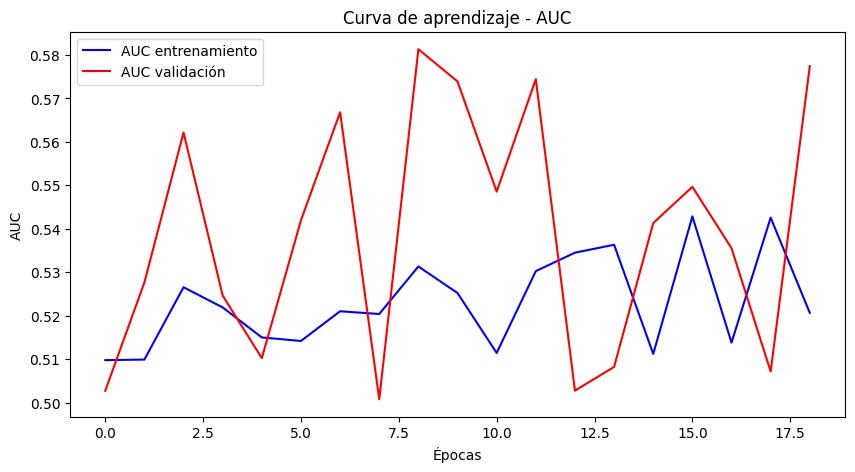

In [ ]:
loss = hist.history[auc.name]
val_loss = hist.history['val_'+auc.name]
plt.figure(figsize=(10, 5))
plt.plot(loss, label='AUC entrenamiento', color='blue')
plt.plot(val_loss, label='AUC validación', color='red')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.title('Curva de aprendizaje - AUC')
plt.legend()
plt.show()


63/63 [==============================] - 0s 3ms/step
ROC AUC: 0.6083517037306748


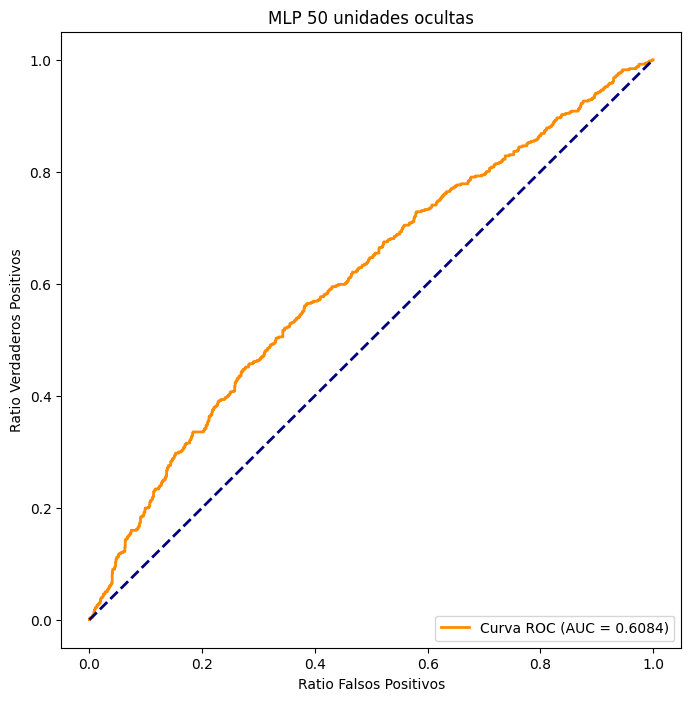

In [ ]:
preds_pos = model.predict(X_test_oh_imp)
preds_pos = np.squeeze(preds_pos)
roc_auc = roc_auc_score(y_test, preds_pos)
print(f'ROC AUC: {roc_auc}')
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, preds_pos)
# Dibujar la curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('MLP 50 unidades ocultas')
plt.legend(loc='lower right')
plt.show()

('epochs-100', 'n_units-[40, 20]', 'drop_rate-0'): 0.6025080259940655,

('epochs-100', 'n_units-[200]', 'drop_rate-0'): 0.6065025166927204}

# MODELO FINAL

## REGRESION

In [ ]:
test_size = 0.15
random_state = 28

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

woe_resultado = fit_woe(X_train, y_train)
_, X_train_woe_filtrado  = dame_woe(X_train, woe_resultado)
reg_log = LogisticRegression(penalty=None, class_weight='balanced', max_iter=500, solver='lbfgs')
reg_log.fit(X_train_woe_filtrado, y_train)
_, X_test_woe_filtrado = dame_woe(X_test, woe_resultado)

X_test_woe_filtrado['target'] = y_test.values
n_datos1 = len(X_test_woe_filtrado)
X_test_woe_filtrado = X_test_woe_filtrado.dropna(how='any')
n_datos2 = len(X_test_woe_filtrado)
print(f'{n_datos1-n_datos2} filas eliminadas de validación.')
y_test = X_test_woe_filtrado['target']
X_test_woe_filtrado = X_test_woe_filtrado.drop('target', axis=1)

preds_reg_log = reg_log.predict_proba(X_test_woe_filtrado) #####
preds_pos_reg_log = preds_reg_log[:,1] # Clase 1
roc_auc_reg_log = roc_auc_score(y_test, preds_pos_reg_log) ####
print(roc_auc_reg_log)

[INFO] creating woe binning ...
Binning on 11408 rows and 48 columns in 00:01:28
[INFO] converting into woe values ...
[INFO] converting into woe values ...
0 filas eliminadas de validación.
0.6151899769529019


## ELASTIC NET

In [ ]:
test_size = 0.15
random_state = 28

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']


add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS
X_new = dame_one_hot(X, add_classna, add_varna)
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=test_size, random_state=random_state, stratify=y)

# PREPROCESAMIENTO
clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train, y_train, n=5)
X_train_oh = dame_one_hot_new_var(X_train, clases_agrupadas, 5)
imputer = fit_imputer(X_train_oh)
X_train_oh_imp = imputa(X_train_oh, imputer)

X_test_oh = dame_one_hot_new_var(X_test, clases_agrupadas, 5)
X_test_oh_imp = imputa(X_test_oh, imputer)
# FIN PREPROCESAMIENTO

el_net = ElasticNet(alpha=0.012, l1_ratio=0.7)
el_net.fit(X_train_oh_imp, y_train)
preds_el_net = el_net.predict(X_test_oh_imp) ######
preds_el_net = (preds_el_net-np.min(preds_el_net))/(np.max(preds_el_net)-np.min(preds_el_net))

roc_auc_el_net = roc_auc_score(y_test, preds_el_net) ####
print(roc_auc_el_net)

0.6207532060795792


## MLP

In [ ]:
auc = tf.keras.metrics.AUC()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_'+auc.name, patience=10, mode='max', verbose=1, restore_best_weights=True)

test_size = 0.15
random_state = 28

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

add_classna = ['DONOR_GENDER', 'INCOME_GROUP', 'WEALTH_RATING']
add_varna = ['MONTHS_SINCE_LAST_PROM_RESP'] # POR LA DIFERENCIA ENTRE MISSINGS-NO_MISSINGS
X_new = dame_one_hot(X, add_classna, add_varna)
print(X_new.shape, y.shape)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_new, y, test_size=test_size, random_state=random_state, stratify=y)
print(X_train_val.shape, y_train_val.shape)
X_train2, X_val, y_train2, y_val = train_test_split(X_train_val, y_train_val, test_size=test_size, random_state=random_state, stratify=y_train_val)
print()

# PREPROCESAMIENTO
clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE'] = fit_reduce_clases('CLUSTER_CODE', X_train_val, y_train_val, n=5)
X_train_oh = dame_one_hot_new_var(X_train2, clases_agrupadas, 5)
imputer = fit_imputer(X_train_oh)
X_train_oh_imp = imputa(X_train_oh, imputer)

X_val_oh = dame_one_hot_new_var(X_val, clases_agrupadas, 5)
X_val_oh_imp = imputa(X_val_oh, imputer)

X_test_oh = dame_one_hot_new_var(X_test, clases_agrupadas, 5)
X_test_oh_imp = imputa(X_test_oh, imputer)
# FIN PREPROCESAMIENTO

model = tf.keras.Sequential([
  tf.keras.layers.Dense(50, activation='relu', input_shape=(X_train_oh_imp.shape[1],)),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
print(model.summary())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[auc])

print('Entrenando =======================')
hist = model.fit(X_train_oh_imp, y_train2, epochs=100, batch_size=64, validation_data=(X_val_oh_imp, y_val), callbacks=[early_stopping], verbose=1)
print('Entrenado ========================')

preds_pos_mlp = model.predict(X_test_oh_imp) ####
preds_pos_mlp = np.squeeze(preds_pos_mlp)
roc_auc_mlp = roc_auc_score(y_test, preds_pos_mlp) ####
print(roc_auc_mlp)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(13422, 86) (13422,)
(11408, 86) (11408,)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 50)                4550      
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4601 (17.97 KB)
Trainable params: 4601 (17.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


<IPython.core.display.Javascript object>

Entrenando =======================
Epoch 1/100
152/152 [==============================] - 2s 8ms/step - loss: 502.8058 - auc_5: 0.4883 - val_loss: 28.0878 - val_auc_5: 0.5142
Epoch 2/100
152/152 [==============================] - 0s 3ms/step - loss: 10.5335 - auc_5: 0.5171 - val_loss: 2.6597 - val_auc_5: 0.5698
Epoch 3/100
152/152 [==============================] - 0s 3ms/step - loss: 5.2582 - auc_5: 0.5174 - val_loss: 4.2738 - val_auc_5: 0.5066
Epoch 4/100
152/152 [==============================] - 0s 3ms/step - loss: 3.3059 - auc_5: 0.5323 - val_loss: 5.6893 - val_auc_5: 0.4996
Epoch 5/100
152/152 [==============================] - 0s 3ms/step - loss: 3.2227 - auc_5: 0.5221 - val_loss: 1.5138 - val_auc_5: 0.5478
Epoch 6/100
152/152 [==============================] - 1s 3ms/step - loss: 2.8155 - auc_5: 0.5157 - val_loss: 2.0702 - val_auc_5: 0.5323
Epoch 7/100
152/152 [==============================] - 1s 5ms/step - loss: 2.5485 - auc_5: 0.5363 - val_loss: 3.8999 - val_auc_5: 0.5051
Ep

# PARTE 2

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer

def preprocess_data2(X):
    # Seleccionar las variables a discretizar
    variables_a_discretizar = ['WEALTH_RATING', 'INCOME_GROUP']

    # Definir los bins para cada variable
    bins_wealth_rating = [0, 1, 2, 3, 4, 5,6,7,8,9,10]
    labels_wealth_rating = ['1', '2', '3', '4', '5', '6','7','8','9','10']

    bins_income_group = [0,1, 2, 3,4,5, 6,7, 8]
    labels_income_group = ['1', '2', '3', '4','5','6','7','8']

    bins_status_rating = [1, 2, 3,4,5]
    labels_status_rating = ['1', '2', '3', '4']

    #bins_age_group = [0, 20, 40, 60, 80, 100]
    #labels_age_group = ['Niño', 'Joven', 'Mediana-Edad', 'Mayor', 'Anciano']

    # Agrupar las categorías 'U' y 'A' en la columna 'DONOR_GENDER'
    X['DONOR_GENDER'] = X['DONOR_GENDER'].replace(['U', 'A'], 'Otros')

    X['RECENCY_STATUS_96NK'] = X['RECENCY_STATUS_96NK'].replace(['E', 'L'], 'Otros')

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['WEALTH_RATING_DISCRETIZED'] = np.select(
        [pd.isna(X['WEALTH_RATING']), True],
        ['Valor Missing', pd.cut(X['WEALTH_RATING'], bins=bins_wealth_rating, labels=labels_wealth_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    # Discretizar y asignar categorías, tratando los missing como 'Valor Missing'
    X['FREQUENCY_STATUS_97NK_DISCRETIZED'] = np.select(
        [pd.isna(X['FREQUENCY_STATUS_97NK']), True],
        ['Valor Missing', pd.cut(X['FREQUENCY_STATUS_97NK'], bins=bins_status_rating, labels=labels_status_rating, include_lowest=True, right=False, duplicates='drop')]
    )

    X['INCOME_GROUP_DISCRETIZED'] = np.select(
        [pd.isna(X['INCOME_GROUP']), True],
        ['Valor Missing', pd.cut(X['INCOME_GROUP'], bins=bins_income_group, labels=labels_income_group, include_lowest=True, right=False, duplicates='drop')]
    )


    # Crear una nueva variable auxiliar indicando si MONTHS_SINCE_LAST_PROM_RESP es NaN
    X['IS_MONTHS_SINCE_LAST_PROM_RESP_NAN'] = pd.isna(X['MONTHS_SINCE_LAST_PROM_RESP']).astype(int)

    # Eliminar las columnas originales
    X = X.drop(['WEALTH_RATING', 'INCOME_GROUP','FREQUENCY_STATUS_97NK'], axis=1)

    return X

## ARBOL

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Inicializar y ajustar el modelo Decision Tree con los mejores hiperparámetros
best_clf = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    ccp_alpha=0,
    min_impurity_decrease=0.001,
    class_weight='balanced',
    random_state = 2019
)

X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']
imputer = KNNImputer(n_neighbors=5)
X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train,y_train,n=5)

X_train['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train['CLUSTER_CODE']]
X_test['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_test['CLUSTER_CODE']]

# Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
X_train['Response_Variable'] = y_train.values


# Bucle para cada columna categórica en X_train
for column in X_train.select_dtypes(include='object').columns:

  # Crear un diccionario que asocie cada clase con su media en la variable respuesta
  class_means = X_train.groupby(column)['Response_Variable'].mean().to_dict()

  # Label Encoding con medias de respuesta
  X_train[column] = X_train[column].map(class_means)
  X_test[column] = X_test[column].map(class_means)

# Eliminar la columna de la variable respuesta después de label encoding
X_train = X_train.drop('Response_Variable', axis=1)

# Imputar los valores missing en X_train_fold usando k-NN
X_train_imputed = imputer.fit_transform(X_train)

# Aplicar la imputación al conjunto de validación (X_val_fold)
X_test_imputed = imputer.transform(X_test)

# Ajustar el modelo
best_clf.fit(X_train_imputed, y_train)

# Realizar predicciones en conjuntos de entrenamiento y validación
y_pred_train = best_clf.predict_proba(X_train_imputed)[:, 1]
preds_arbol = best_clf.predict_proba(X_test_imputed)[:, 1] #######

# Calcular y almacenar las métricas de rendimiento por pliegue
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_arbol = roc_auc_score(y_test, preds_arbol) ###
print(roc_auc_arbol)

0.6089559150040963


## RANDOM FOREST

In [ ]:

import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

# Inicializar y ajustar el modelo Decision Tree con los mejores hiperparámetros
best_clf = RandomForestClassifier(
        n_estimators=50,
        min_samples_split=2,
        ccp_alpha=0.001,
        max_depth = 20,
        min_impurity_decrease=0,
        class_weight='balanced',
        random_state=2019,
        n_jobs=-1
)

X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train,y_train,n=5)

X_train['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train['CLUSTER_CODE']]
X_test['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_test['CLUSTER_CODE']]

# Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
X_train['Response_Variable'] = y_train.values

# Bucle para cada columna categórica en X_train
for column in X_train.select_dtypes(include='object').columns:

  # Crear un diccionario que asocie cada clase con su media en la variable respuesta
  class_means = X_train.groupby(column)['Response_Variable'].mean().to_dict()

  # Label Encoding con medias de respuesta
  X_train[column] = X_train[column].map(class_means)
  X_test[column] = X_test[column].map(class_means)

# Eliminar la columna de la variable respuesta después de label encoding
X_train = X_train.drop('Response_Variable', axis=1)

# Imputar los valores missing en X_train_fold usando k-NN
X_train_imputed = imputer.fit_transform(X_train)

# Aplicar la imputación al conjunto de validación (X_val_fold)
X_test_imputed = imputer.transform(X_test)

# Ajustar el modelo
best_clf.fit(X_train_imputed, y_train)

# Realizar predicciones en conjuntos de entrenamiento y validación
y_pred_train = best_clf.predict_proba(X_train_imputed)[:, 1]
preds_rf = best_clf.predict_proba(X_test_imputed)[:, 1] ####

# Calcular y almacenar las métricas de rendimiento por pliegue
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_rf = roc_auc_score(y_test, preds_rf) ####
print(roc_auc_rf)




0.6283302529112298


## GRADIENT BOOSTING

In [ ]:
###GRADIENT BOOSTING: Combinaciones ganadoras -> 600, 4, auto, 0.005 | 200, 5 , auto, 0.01


import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')

X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Inicializar y ajustar el modelo Decision Tree con los mejores hiperparámetros
best_clf_g = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method='auto',
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
        )

clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train,y_train,n=5)

X_train['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train['CLUSTER_CODE']]
X_test['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_test['CLUSTER_CODE']]

# Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
X_train['Response_Variable'] = y_train.values
X_test['Response_Variable'] = y_test.values

# Bucle para cada columna categórica en X_train
for column in X_train.select_dtypes(include='object').columns:

  # Crear un diccionario que asocie cada clase con su media en la variable respuesta
  class_means = X_train.groupby(column)['Response_Variable'].mean().to_dict()

  # Label Encoding con medias de respuesta
  X_train[column] = X_train[column].map(class_means)
  X_test[column] = X_test[column].map(class_means)

# Eliminar la columna de la variable respuesta después de label encoding
X_train = X_train.drop('Response_Variable', axis=1)
X_test = X_test.drop('Response_Variable', axis=1)


# Ajustar el modelo
best_clf_g.fit(X_train, y_train)

# Realizar predicciones en conjuntos de entrenamiento y validación
y_pred_train = best_clf_g.predict_proba(X_train)[:, 1]
preds_gb = best_clf_g.predict_proba(X_test)[:, 1] ####

# Calcular y almacenar las métricas de rendimiento por pliegue
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_preds_gb = roc_auc_score(y_test, preds_gb) ####
print(roc_auc_preds_gb)

0.6389600178361057


In [ ]:
###GRADIENT BOOSTING: Combinaciones ganadoras -> 600, 4, auto, 0.005 | 200, 5 , auto, 0.01


import os
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
import itertools
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier

alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')

X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']

X_proc =preprocess_data2(X)

# Lee los datos y divide en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

# Calcular el peso de clases para manejar desbalance
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# Inicializar y ajustar el modelo Decision Tree con los mejores hiperparámetros
best_clf_g2 = xgb.XGBClassifier(
        n_estimators=600,
        max_depth=4,
        learning_rate=0.005,
        subsample=0.66,
        colsample_bytree=0.66,
        random_state=2019,
        tree_method='auto',
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
        )

clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train,y_train,n=5)

X_train['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train['CLUSTER_CODE']]
X_test['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_test['CLUSTER_CODE']]

# Añadir la columna de la variable respuesta a X_train_fold y X_val_fold
X_train['Response_Variable'] = y_train.values
X_test['Response_Variable'] = y_test.values

# Bucle para cada columna categórica en X_train
for column in X_train.select_dtypes(include='object').columns:

  # Crear un diccionario que asocie cada clase con su media en la variable respuesta
  class_means = X_train.groupby(column)['Response_Variable'].mean().to_dict()

  # Label Encoding con medias de respuesta
  X_train[column] = X_train[column].map(class_means)
  X_test[column] = X_test[column].map(class_means)

# Eliminar la columna de la variable respuesta después de label encoding
X_train = X_train.drop('Response_Variable', axis=1)
X_test = X_test.drop('Response_Variable', axis=1)

# Ajustar el modelo
best_clf_g2.fit(X_train, y_train)

# Realizar predicciones en conjuntos de entrenamiento y validación
y_pred_train = best_clf_g2.predict_proba(X_train)[:, 1]
preds_gb_2 = best_clf_g2.predict_proba(X_test)[:, 1] ####

# Calcular y almacenar las métricas de rendimiento por pliegue
roc_auc_train = roc_auc_score(y_train, y_pred_train)
roc_auc_preds_gb_2 = roc_auc_score(y_test, preds_gb_2) ####
print(roc_auc_preds_gb_2)

0.638122301332563


In [ ]:
print(roc_auc_train)

0.7072926038593195


# DIBUJAMOS EL AUC

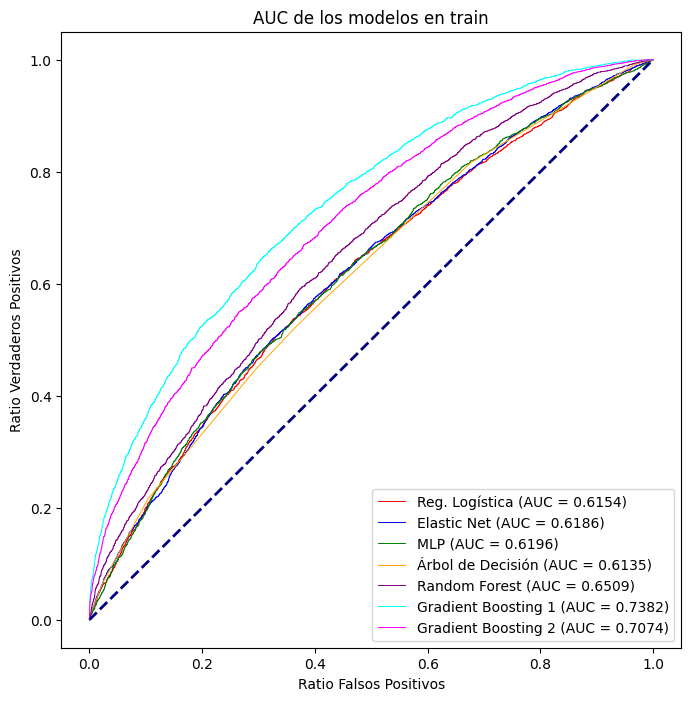

In [ ]:
# Calcular la curva ROC
fpr1, tpr1, _ = roc_curve(y_test, preds_pos_reg_log)
fpr2, tpr2, _ = roc_curve(y_test, preds_el_net)
fpr3, tpr3, _ = roc_curve(y_test, preds_pos_mlp)
fpr4, tpr4, _ = roc_curve(y_test, preds_arbol)
fpr5, tpr5, _ = roc_curve(y_test, preds_rf)
fpr6, tpr6, _ = roc_curve(y_test, preds_gb)
fpr7, tpr7, _ = roc_curve(y_test, preds_gb_2)
# Dibujar la curva ROC
plt.figure(figsize=(8, 8))

plt.plot(fpr1, tpr1, color='red', lw=0.7, label='Reg. Logística (AUC = {:.4f})'.format(roc_auc_reg_log))
plt.plot(fpr2, tpr2, color='blue', lw=0.7, label='Elastic Net (AUC = {:.4f})'.format(roc_auc_el_net))
plt.plot(fpr3, tpr3, color='green', lw=0.7, label='MLP (AUC = {:.4f})'.format(roc_auc_mlp))
plt.plot(fpr4, tpr4, color='orange', lw=0.7, label='Árbol de Decisión (AUC = {:.4f})'.format(roc_auc_arbol))
plt.plot(fpr5, tpr5, color='purple', lw=0.7, label='Random Forest (AUC = {:.4f})'.format(roc_auc_rf))
plt.plot(fpr6, tpr6, color='cyan', lw=0.7, label='Gradient Boosting 1 (AUC = {:.4f})'.format(roc_auc_preds_gb))
plt.plot(fpr7, tpr7, color='magenta', lw=0.7, label='Gradient Boosting 2 (AUC = {:.4f})'.format(roc_auc_preds_gb_2))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Ratio Falsos Positivos')
plt.ylabel('Ratio Verdaderos Positivos')
plt.title('AUC de los modelos en train')
plt.legend(loc='lower right')
plt.savefig('auctest.png')
plt.show()

## METALEARNER

Cogemos los dos gradient boosting random forest y la elastic net

In [ ]:
aucs_sum = roc_auc_el_net + roc_auc_rf + roc_auc_preds_gb + roc_auc_preds_gb_2
preds_finales = (roc_auc_el_net*preds_el_net + roc_auc_rf*preds_rf + roc_auc_preds_gb*preds_gb + roc_auc_preds_gb_2*preds_gb_2)/aucs_sum
roc_auc_FINAL = roc_auc_score(y_test, preds_finales)
print(roc_auc_FINAL)

0.6348070547602744


PROBAMOS SOLO LOS GRADIENT EMBUSTEROS

In [ ]:
aucs_sum = roc_auc_preds_gb + roc_auc_preds_gb_2
preds_finales2 = (roc_auc_preds_gb*preds_gb + roc_auc_preds_gb_2*preds_gb_2)/aucs_sum
roc_auc_FINAL = roc_auc_score(y_test, preds_finales2)
print(roc_auc_FINAL)

0.6394732016469374


# cogemos los dos gradient embusteros

In [ ]:
alumnos_df = pd.read_csv('veteranos_tablaAlumnos_CSV.csv')
X = alumnos_df.drop(['CONTROL_NUMBER_N', 'TARGET_B'], axis=1)
y = alumnos_df['TARGET_B']
X_proc =preprocess_data2(X)
X_train, _, y_train, _ = train_test_split(X_proc, y, test_size=0.15, random_state=28, stratify=y)

profe_df = pd.read_csv('veteranos_tablaProfe_CSV.csv')
ID = profe_df['CONTROL_NUMBER_N']
X_test = profe_df.drop(['CONTROL_NUMBER_N'], axis=1)
X_test = preprocess_data2(X_test)

clases_agrupadas = {}
clases_agrupadas['CLUSTER_CODE']= fit_reduce_clases('CLUSTER_CODE',X_train,y_train,n=5)

X_train['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_train['CLUSTER_CODE']]
X_test['CLUSTER_CODE']=[clases_agrupadas['CLUSTER_CODE'][-1] if pd.isna(x) else clases_agrupadas['CLUSTER_CODE'][x] for x in X_test['CLUSTER_CODE']]

X_train['Response_Variable'] = y_train.values
# Bucle para cada columna categórica en X_train
for column in X_train.select_dtypes(include='object').columns:

  # Crear un diccionario que asocie cada clase con su media en la variable respuesta
  class_means = X_train.groupby(column)['Response_Variable'].mean().to_dict()

  # Label Encoding con medias de respuesta
  X_train[column] = X_train[column].map(class_means)
  X_test[column] = X_test[column].map(class_means)

# Eliminar la columna de la variable respuesta después de label encoding
X_train = X_train.drop('Response_Variable', axis=1)

In [ ]:
preds_gb_1_profe = best_clf_g.predict_proba(X_test)[:, 1]
preds_gb_2_profe = best_clf_g2.predict_proba(X_test)[:, 1]
aucs_sum = roc_auc_preds_gb + roc_auc_preds_gb_2
preds_gb_profe = (roc_auc_preds_gb*preds_gb_1_profe + roc_auc_preds_gb_2*preds_gb_2_profe)/aucs_sum


In [ ]:
ID.shape, X_test.shape

((5950,), (5950, 48))

In [ ]:
result = pd.DataFrame()
result['CONTROL_NUMBER_N'] = ID
result['SCORES'] = preds_gb_profe

In [ ]:
display(result)

,CONTROL_NUMBER_N,SCORES
0,13423,0.496290
1,13424,0.357075
2,13425,0.523489
3,13426,0.646447
4,13427,0.581787
...,...,...
5945,19368,0.519366
5946,19369,0.588665
5947,19370,0.467570
5948,19371,0.418784


In [ ]:
result.to_csv('scores_profe.csv', index=False)